In [1]:
# Import modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import seaborn as sns
import statsmodels.formula.api as smf

# Data loading

## Movie data

movie.metadata.tsv.gz [3.4 M]
Metadata for 81,741 movies, extracted from November 4, 2012 dump of Freebase. Tab-separated; columns:
- Wikipedia movie ID
- Freebase movie ID
- Movie name
- Movie release date
- Movie box office revenue
- Movie runtime
- Movie languages (Freebase ID:name tuples)
- Movie countries (Freebase ID:name tuples)
- Movie genres (Freebase ID:name tuples)

In [2]:
# Load films
movies_header = ['wikipedia_id', 'freebase_id', 'name', 'release_date', 'box_office_revenue', 'runtime', 'languages', 'countries', 'genres']
movies = pd.read_csv('data/movie.metadata.tsv', sep='\t', header=None, names=movies_header)
movies.head(5)
print(movies.shape)
#movies['runtime'].hist()


(81741, 9)


In [3]:
movies.head(5)

,wikipedia_id,freebase_id,name,release_date,box_office_revenue,runtime,languages,countries,genres
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science..."
1,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,2000-02-16,NaN,95.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/02n4kr"": ""Mystery"", ""/m/03bxz7"": ""Biograp..."
2,28463795,/m/0crgdbh,Brun bitter,1988,NaN,83.0,"{""/m/05f_3"": ""Norwegian Language""}","{""/m/05b4w"": ""Norway""}","{""/m/0lsxr"": ""Crime Fiction"", ""/m/07s9rl0"": ""D..."
3,9363483,/m/0285_cd,White Of The Eye,1987,NaN,110.0,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}","{""/m/01jfsb"": ""Thriller"", ""/m/0glj9q"": ""Erotic..."
4,261236,/m/01mrr1,A Woman in Flames,1983,NaN,106.0,"{""/m/04306rv"": ""German Language""}","{""/m/0345h"": ""Germany""}","{""/m/07s9rl0"": ""Drama""}"


In [4]:
movies.describe()

,wikipedia_id,box_office_revenue,runtime
count,8.174100e+04,8.401000e+03,6.129100e+04
mean,1.740784e+07,4.799363e+07,1.118192e+02
std,1.098791e+07,1.121753e+08,4.360070e+03
min,3.300000e+02,1.000000e+04,0.000000e+00
25%,7.323695e+06,2.083193e+06,8.100000e+01
50%,1.777899e+07,1.063969e+07,9.300000e+01
75%,2.715573e+07,4.071696e+07,1.060000e+02
max,3.750192e+07,2.782275e+09,1.079281e+06


## Character data

character.metadata.tsv.gz [14 M]
Metadata for 450,669 characters aligned to the movies above, extracted from November 4, 2012 dump of Freebase. Tab-separated; columns:

- Wikipedia movie ID
- Freebase movie ID
- Movie release date
- Character name
- Actor date of birth
- Actor gender
- Actor height (in meters)
- Actor ethnicity (Freebase ID)
- Actor name
- Actor age at movie release
- Freebase character/actor map ID
- Freebase character ID
- Freebase actor ID

In [5]:
# Load characters
characters_header = ['wikipedia_movie_id','freebase_movie_id','movie_release_date','character_name','actor_birthdate','actor_gender','actor_height_meters','actor_ethnicity_freebase_id','actor_name','actor_age_at_movie_release','freebase_character_actor_map_id','freebase_character_id','freebase_actor_id']
characters = pd.read_csv('data/character.metadata.tsv', sep='\t', header=None, names=characters_header)
characters.sample(5)

,wikipedia_movie_id,freebase_movie_id,movie_release_date,character_name,actor_birthdate,actor_gender,actor_height_meters,actor_ethnicity_freebase_id,actor_name,actor_age_at_movie_release,freebase_character_actor_map_id,freebase_character_id,freebase_actor_id
319709,5922463,/m/0fdqs4,2004-09-23,Zombie at Video Store,NaN,M,NaN,NaN,Stephen Johnson,NaN,/m/0krw67d,/m/0krw67h,/m/0krw67q
375724,10349642,/m/02q942q,2005,NaN,NaN,NaN,NaN,NaN,Mare Trevathan Phillpott,NaN,/m/0gc6g9m,NaN,/m/0gc4mjp
193103,22217327,/m/05q7vh1,1986-09-09,Reshma Rai,1957-06-08,F,1.59,/m/0g0x7_,Dimple Kapadia,29.0,/m/05tfvqv,/m/0h8k0c8,/m/04rs6k
80955,10354785,/m/02q9895,1998-11-01,Becky Sharp,1969-10-02,F,NaN,NaN,Natasha Little,29.0,/m/02vc4j1,/m/02r2s15,/m/026w9_3
127024,6046767,/m/0fmcr3,2004-07-20,NaN,NaN,M,NaN,NaN,John Fiorella,NaN,/m/0jy_85,NaN,/m/0jy_7m


Let's map the wikipedia_movie_id to the movie name given in movies 'name' column

In [6]:
characters = characters.merge(movies[['wikipedia_id','name']], how='left', left_on='wikipedia_movie_id', right_on='wikipedia_id')
characters.drop('wikipedia_id', inplace=True, axis=1)

In [7]:
characters.head()

,wikipedia_movie_id,freebase_movie_id,movie_release_date,character_name,actor_birthdate,actor_gender,actor_height_meters,actor_ethnicity_freebase_id,actor_name,actor_age_at_movie_release,freebase_character_actor_map_id,freebase_character_id,freebase_actor_id,name
0,975900,/m/03vyhn,2001-08-24,Akooshay,1958-08-26,F,1.620,NaN,Wanda De Jesus,42.0,/m/0bgchxw,/m/0bgcj3x,/m/03wcfv7,Ghosts of Mars
1,975900,/m/03vyhn,2001-08-24,Lieutenant Melanie Ballard,1974-08-15,F,1.780,/m/044038p,Natasha Henstridge,27.0,/m/0jys3m,/m/0bgchn4,/m/0346l4,Ghosts of Mars
2,975900,/m/03vyhn,2001-08-24,Desolation Williams,1969-06-15,M,1.727,/m/0x67,Ice Cube,32.0,/m/0jys3g,/m/0bgchn_,/m/01vw26l,Ghosts of Mars
3,975900,/m/03vyhn,2001-08-24,Sgt Jericho Butler,1967-09-12,M,1.750,NaN,Jason Statham,33.0,/m/02vchl6,/m/0bgchnq,/m/034hyc,Ghosts of Mars
4,975900,/m/03vyhn,2001-08-24,Bashira Kincaid,1977-09-25,F,1.650,NaN,Clea DuVall,23.0,/m/02vbb3r,/m/0bgchp9,/m/01y9xg,Ghosts of Mars


## Official IMDb dataset

This dataset includes all IMDb data. https://www.imdb.com/interfaces/

title.basics.tsv.gz
 - tconst (string) - alphanumeric unique identifier of the title
 - titleType (string) – the type/format of the title (e.g. movie, short, tvseries, tvepisode, video, etc)
 - primaryTitle (string) – the more popular title / the title used by the filmmakers on promotional materials at the point of release
 - originalTitle (string) - original title, in the original language
 - isAdult (boolean) - 0: non-adult title; 1: adult title
 - startYear (YYYY) – represents the release year of a title. In the case of TV Series, it is the series start year
 - endYear (YYYY) – TV Series end year. ‘\N’ for all other title types
 - runtimeMinutes – primary runtime of the title, in minutes
 - genres (string array) – includes up to three genres associated with the title

title.ratings.tsv.gz
 - tconst (string) - alphanumeric unique identifier of the title
 - averageRating – weighted average of all the individual user ratings
 - numVotes - number of votes the title has received

title.crew.tsv.gz
 - tconst (string) - alphanumeric unique identifier of the title
 - directors (array of nconsts) - director(s) of the given title
 - writers (array of nconsts) – writer(s) of the given title

name.basics.tsv.gz: information of actors
 - nconst (string) - alphanumeric unique identifier of the name/person
 - primaryName (string)– name by which the person is most often credited
 - birthYear – in YYYY format
 - deathYear – in YYYY format if applicable, else '\N'
 - primaryProfession (array of strings)– the top-3 professions of the person
 - knownForTitles (array of tconsts) – titles the person is known for

In [8]:
imdb_titles = pd.read_csv('./data/imdb/imdb_titles.tsv', na_values='\\N', sep='\t')
imdb_ratings = pd.read_csv('./data/imdb/imdb_ratings.tsv', na_values='\\N', sep='\t')
imdb_crew = pd.read_csv('./data/imdb/imdb_crew.tsv', na_values='\\N', sep='\t')
imdb_people = pd.read_csv('./data/imdb/imdb_people.tsv', na_values='\\N', sep='\t')

In [9]:
imdb_titles.head()

,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres
0,tt0000001,short,Carmencita,Carmencita,0,1894.0,NaN,1.0,"Documentary,Short"
1,tt0000002,short,Le clown et ses chiens,Le clown et ses chiens,0,1892.0,NaN,5.0,"Animation,Short"
2,tt0000003,short,Pauvre Pierrot,Pauvre Pierrot,0,1892.0,NaN,4.0,"Animation,Comedy,Romance"
3,tt0000004,short,Un bon bock,Un bon bock,0,1892.0,NaN,12.0,"Animation,Short"
4,tt0000005,short,Blacksmith Scene,Blacksmith Scene,0,1893.0,NaN,1.0,"Comedy,Short"


In [10]:
imdb_ratings.head()

,tconst,averageRating,numVotes
0,tt0000001,5.7,1923
1,tt0000002,5.8,260
2,tt0000003,6.5,1738
3,tt0000004,5.6,175
4,tt0000005,6.2,2553


In [11]:
imdb_crew.head()

,tconst,directors,writers
0,tt0000001,nm0005690,NaN
1,tt0000002,nm0721526,NaN
2,tt0000003,nm0721526,NaN
3,tt0000004,nm0721526,NaN
4,tt0000005,nm0005690,NaN


In [12]:
imdb_people.head()

,nconst,primaryName,birthYear,deathYear,primaryProfession,knownForTitles
0,nm0000001,Fred Astaire,1899.0,1987.0,"soundtrack,actor,miscellaneous","tt0031983,tt0072308,tt0053137,tt0050419"
1,nm0000002,Lauren Bacall,1924.0,2014.0,"actress,soundtrack","tt0071877,tt0037382,tt0038355,tt0117057"
2,nm0000003,Brigitte Bardot,1934.0,NaN,"actress,soundtrack,music_department","tt0054452,tt0049189,tt0057345,tt0056404"
3,nm0000004,John Belushi,1949.0,1982.0,"actor,soundtrack,writer","tt0077975,tt0078723,tt0080455,tt0072562"
4,nm0000005,Ingmar Bergman,1918.0,2007.0,"writer,director,actor","tt0083922,tt0060827,tt0050986,tt0050976"


In [13]:
imdb_people.describe()

,birthYear,deathYear
count,568354.000000,208794.000000
mean,1952.249489,1991.615310
std,34.844203,34.748459
min,4.000000,17.000000
25%,1931.000000,1978.000000
50%,1959.000000,2000.000000
75%,1978.000000,2013.000000
max,2022.000000,2022.000000


## IMDB budget data:

This dataset includes the ratings for 3828 IMDB movies. 
source: https://github.com/jeremy-lee93/dsc-mod-1-project-v2-1-onl01-dtsc-pt-052620/blob/master/IMDb_budgets.csv

- Movie:  Title of movie
- Year: Movie release year
- IMDb: IMDB rating over 10
- Rating: Certificate
- Runtime [min]
- Genre
- Release Date: Movie release date
- Production Budget: Budget spent for production of the movie
- Domestic Gross: Gross revenue in US and Canada for all time
- Worldwide Gross: Worldwide gross revenue for all time

In [14]:
imdb_budget = pd.read_csv('data/imdb/IMDb_budgets.csv')

In [15]:
imdb_budget.sample(5)

,Movie,Year,IMDb,Rating,Runtime,Genre,Release Date,Production Budget,Domestic Gross,Worldwide Gross
1016,Pitch Perfect,2012,7.2,PG-13,112,"Comedy, Music, Romance","Sep 28, 2012",17000000,65001093,116044347
646,Zero Dark Thirty,2012,7.4,R,157,"Drama, History, Thriller","Dec 19, 2012",52500000,95720716,134612435
1379,The Land Before Time,1988,7.4,G,69,"Animation, Adventure, Drama","Nov 18, 1988",12300000,48092846,81972846
70,The Twilight Saga: Eclipse,2010,5.0,PG-13,124,"Adventure, Drama, Fantasy","Jun 30, 2010",68000000,300531751,706102828
298,X-Men,2000,7.4,PG-13,104,"Action, Adventure, Sci-Fi","Jul 14, 2000",75000000,157299717,296872367


In [16]:
imdb_budget.describe()

,Year,IMDb,Runtime,Production Budget,Domestic Gross,Worldwide Gross
count,3828.000000,3828.000000,3828.000000,3.828000e+03,3.828000e+03,3.828000e+03
mean,2003.594044,6.459013,109.940439,4.030960e+07,5.559021e+07,1.206910e+08
std,12.767740,0.996623,20.219674,4.480927e+07,7.403263e+07,1.993646e+08
min,1925.000000,1.500000,63.000000,7.000000e+03,0.000000e+00,0.000000e+00
25%,1999.000000,5.900000,96.000000,1.100000e+07,1.180967e+07,1.690363e+07
50%,2006.000000,6.500000,106.000000,2.500000e+07,3.225471e+07,5.077617e+07
75%,2013.000000,7.100000,120.000000,5.000000e+07,6.848642e+07,1.388776e+08
max,2020.000000,9.300000,271.000000,4.000000e+08,8.583730e+08,2.797801e+09


## Wikipedia

Wikipedia page views statistics
source: this data is crowed from the wikimedia API by the ./utils/wikipedia_pageview_statistics.py script
    
- `name`: Title of a movie
- `pageviews`: Number of page views for a movie with a `name`. The value is an weighted aggregation for the pageviews for the period between 01/12/2021 and 30/11/2022. The weight is computed with this formula - `weight = 1 + ((2022 - movie_release_year) / (2022 - min_movie_year))`. The aggregation is accomplished by the `mean` function.

In [17]:
wikipedia_pageviews = pd.read_csv('./handled_data/movies_wikipedia_pageviews.csv')

In [18]:
wikipedia_pageviews.sample(5)

,name,pageviews
71073,Wells Fargo,75406.193758
39345,Navajo Joe,2661.821146
25500,How I Wonder What You Are,24.706192
30750,Kurenai no buta,11.326087
34051,Love Letter,28.128788


# Cleaning & Pre-processing of data

In [19]:
movies.describe()

,wikipedia_id,box_office_revenue,runtime
count,8.174100e+04,8.401000e+03,6.129100e+04
mean,1.740784e+07,4.799363e+07,1.118192e+02
std,1.098791e+07,1.121753e+08,4.360070e+03
min,3.300000e+02,1.000000e+04,0.000000e+00
25%,7.323695e+06,2.083193e+06,8.100000e+01
50%,1.777899e+07,1.063969e+07,9.300000e+01
75%,2.715573e+07,4.071696e+07,1.060000e+02
max,3.750192e+07,2.782275e+09,1.079281e+06


In [20]:
characters.describe()

,wikipedia_movie_id,actor_height_meters,actor_age_at_movie_release
count,4.506690e+05,154824.000000,292556.000000
mean,1.396975e+07,1.788893,37.788523
std,1.079662e+07,4.379940,20.587870
min,3.300000e+02,0.610000,-7896.000000
25%,3.759292e+06,1.676400,28.000000
50%,1.189065e+07,1.750000,36.000000
75%,2.366501e+07,1.830000,47.000000
max,3.750192e+07,510.000000,103.000000


In [21]:
# Function to remove encoding: 
remove_encoding = lambda x: np.nan if x == '{}' else \
    [w.replace(' Language', '').replace(' language', '') for w in re.findall(r'"(.*?)"', x)[1::2]]

In [22]:
movies['genres'] = movies['genres'].apply(remove_encoding)
movies['languages'] = movies['languages'].apply(remove_encoding)
movies['countries'] = movies['countries'].apply(remove_encoding)
movies.head()

,wikipedia_id,freebase_id,name,release_date,box_office_revenue,runtime,languages,countries,genres
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,[English],[United States of America],"[Thriller, Science Fiction, Horror, Adventure,..."
1,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,2000-02-16,NaN,95.0,[English],[United States of America],"[Mystery, Biographical film, Drama, Crime Drama]"
2,28463795,/m/0crgdbh,Brun bitter,1988,NaN,83.0,[Norwegian],[Norway],"[Crime Fiction, Drama]"
3,9363483,/m/0285_cd,White Of The Eye,1987,NaN,110.0,[English],[United Kingdom],"[Thriller, Erotic thriller, Psychological thri..."
4,261236,/m/01mrr1,A Woman in Flames,1983,NaN,106.0,[German],[Germany],[Drama]


In [23]:
movies['countries'].apply(np.shape).min()

()

### Clean release dates

In [24]:
# Replace string 'release_date' column with 3 float columns ['release_year','release_month','release_day']

movies['release_date'] = movies['release_date'].astype('str') # Convert to string all dates
release_date = pd.DataFrame(movies['release_date'].str.split('-', expand=True).values, columns=['release_year','release_month','release_day']) # Split between days, months and year
movies[['release_year','release_month','release_day']] = release_date
movies = movies.drop('release_date', axis=1)


In [25]:
movies.head()

,wikipedia_id,freebase_id,name,box_office_revenue,runtime,languages,countries,genres,release_year,release_month,release_day
0,975900,/m/03vyhn,Ghosts of Mars,14010832.0,98.0,[English],[United States of America],"[Thriller, Science Fiction, Horror, Adventure,...",2001,08,24
1,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,NaN,95.0,[English],[United States of America],"[Mystery, Biographical film, Drama, Crime Drama]",2000,02,16
2,28463795,/m/0crgdbh,Brun bitter,NaN,83.0,[Norwegian],[Norway],"[Crime Fiction, Drama]",1988,None,None
3,9363483,/m/0285_cd,White Of The Eye,NaN,110.0,[English],[United Kingdom],"[Thriller, Erotic thriller, Psychological thri...",1987,None,None
4,261236,/m/01mrr1,A Woman in Flames,NaN,106.0,[German],[Germany],[Drama],1983,None,None


### Remove data that is out of this world 

In [26]:
def replace_outliers_with_nan(df, col, possible_range):
    df[col] = df[col].apply(lambda x: np.nan if x < possible_range[0] or x > possible_range[1] else x)

#### Movies

In [27]:
possible_movie_runtime_range = [0, 85 * 60] # 85 hours is the Guinness World Record for the longest movie - The Cure for Insomnia

In [28]:
replace_outliers_with_nan(movies, 'runtime', possible_movie_runtime_range)

In [29]:
movies.describe()

,wikipedia_id,box_office_revenue,runtime
count,8.174100e+04,8.401000e+03,61286.000000
mean,1.740784e+07,4.799363e+07,93.651871
std,1.098791e+07,1.121753e+08,51.513103
min,3.300000e+02,1.000000e+04,0.000000
25%,7.323695e+06,2.083193e+06,81.000000
50%,1.777899e+07,1.063969e+07,93.000000
75%,2.715573e+07,4.071696e+07,106.000000
max,3.750192e+07,2.782275e+09,5100.000000


In [30]:
movies[movies['runtime'] == 0]

,wikipedia_id,freebase_id,name,box_office_revenue,runtime,languages,countries,genres,release_year,release_month,release_day
42478,786716,/m/03c6bq,Dickson Experimental Sound Film,NaN,0.0,[English],[United States of America],[Short Film],1894,None,None


The real length of Dickson Experimental Sound Film is 17 seconds which rounded to minutes is 0.

#### Characters

Remove age and height that are incorrect or corrupted

In [31]:
possible_age_range = (0, 150)
possible_height_range = (0, 3)

In [32]:
replace_outliers_with_nan(characters, 'actor_age_at_movie_release', possible_age_range)
replace_outliers_with_nan(characters, 'actor_height_meters', possible_height_range)

A very important characteristic describing the characters is their ethnicity. In the original dataset only the freebase id referring to the ethnicity was available. Thus, a script that can be found in `utils/ethnicities_freebase_ids_script.py` has been created to relate it to the actual labels (p.e. '/m/0152s7' stands for 'Anglo-Irish people'). A CSV has been created to map the ids and the labels, it can be found in `handled_data/ethnicities_freebase_ids.csv`. This is how it looks like:Add ethnicity labels using the freebase ethnicity ids

In [33]:
ethnicity_freebase_ids = pd.read_csv('handled_data/ethnicities_freebase_ids.csv')
ethnicity_freebase_ids.head(5)

,ethnicity_freebase_id,ethnicity_label
0,/m/01267,Albanians
1,/m/012c1l,French Canadians
2,/m/012f86,Ukrainians
3,/m/012fh,Afrikaners
4,/m/01336l,Asian Americans


As it can be seen, the ethnicities are extremely specific and it is very difficult to extract some conclusions. Therefore, we grouped all ethnicities that are repeated more than 10 times into five main ethnic groups: Asian, Black, Latino, Indian and White. This classification can be found in the CSV document in `handled_data/major_ethnicities_clustering.csv`. This is how it looks like:

In [34]:
major_ethnicities = pd.read_csv('handled_data/major_ethnicities_clustering.csv',sep=',');
major_ethnicities.head(10)

,ethnicity_label,major_ethnicity
0,African Americans,Black
1,American Jews,White
2,Americans,White
3,Argentines,Latino
4,Ashkenazi Jews,White
5,Asian Americans,Asian
6,Asian people,Asian
7,Australians,White
8,Austrians,White
9,Bengali people,Indian


Next step is to merge this two tables into the characters main dataframe

In [35]:
characters = pd.merge(characters, ethnicity_freebase_ids, how='left', left_on='actor_ethnicity_freebase_id', right_on='ethnicity_freebase_id')
characters.drop('ethnicity_freebase_id', inplace=True, axis=1)
characters = pd.merge(characters, major_ethnicities, how='left', on='ethnicity_label')

Finally, this the characters main data frame in which we are working

In [36]:
characters.sample(5)

,wikipedia_movie_id,freebase_movie_id,movie_release_date,character_name,actor_birthdate,actor_gender,actor_height_meters,actor_ethnicity_freebase_id,actor_name,actor_age_at_movie_release,freebase_character_actor_map_id,freebase_character_id,freebase_actor_id,name,ethnicity_label,major_ethnicity
92544,740744,/m/037cr1,2003-12-09,Mary Darling,1968-07-26,F,1.74,NaN,Olivia Williams,35.0,/m/0cgr39c,/m/03gr26t,/m/07b2lv,Peter Pan,NaN,NaN
113871,25867384,/m/09v56qz,2008,NaN,1964-07-07,M,NaN,NaN,Shinichi Tsutsumi,43.0,/m/0h7vg9r,NaN,/m/0gnb0g,Climber's High,NaN,NaN
73949,28478510,/m/09rr333,1950,NaN,1907-06-29,F,NaN,NaN,Joan Davis,42.0,/m/0cv4hh3,NaN,/m/074q_g,Love That Brute,NaN,NaN
125054,2354153,/m/076162,1949,NaN,1910-10-27,M,1.88,NaN,Jack Carson,38.0,/m/02tb7v8,NaN,/m/07crf5,It's a Great Feeling,NaN,NaN
220778,18732149,/m/04gh25y,1975-03-17,NaN,1934-02-17,M,1.80,NaN,Alan Bates,41.0,/m/04lrzjt,NaN,/m/015gw6,In Celebration,NaN,NaN


In [37]:
characters.describe()

,wikipedia_movie_id,actor_height_meters,actor_age_at_movie_release
count,4.536250e+05,157666.000000,294959.000000
mean,1.393780e+07,1.747917,37.925895
std,1.079782e+07,0.106067,14.096938
min,3.300000e+02,0.610000,0.000000
25%,3.738820e+06,1.676400,28.000000
50%,1.180718e+07,1.750000,36.000000
75%,2.362455e+07,1.830000,47.000000
max,3.750192e+07,2.356000,103.000000


### IMDB

In [38]:
def split_list(df, column_name, sep=','):
    df[column_name] = df[column_name].replace(np.nan, '').apply(lambda x: x.split(sep))

In [39]:
def fill_na_with_list(df, column_name):
    df[column_name] = df[column_name].fillna('').apply(list)

In [40]:
split_list(imdb_crew, 'directors')
split_list(imdb_crew, 'writers')
split_list(imdb_titles, 'genres')

In [41]:
imdb_people_dict = dict(zip(imdb_people['nconst'], imdb_people['primaryName']))

In [42]:
imdb_crew['directors'] = imdb_crew['directors'].apply(lambda _list: [imdb_people_dict[el] for el in _list if el in imdb_people_dict])

In [43]:
imdb_crew['writers'] = imdb_crew['writers'].apply(lambda _list: [imdb_people_dict[el] for el in _list if el in imdb_people_dict])

In [44]:
imdb = pd.merge(pd.merge(imdb_titles, imdb_ratings, how='inner', on='tconst'), imdb_crew, how='inner', on='tconst')

In [45]:
# Free memory
del imdb_titles
del imdb_ratings
del imdb_crew

In [46]:
imdb.sample(5)

,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres,averageRating,numVotes,directors,writers
938797,tt3466684,short,Nocebo,Nocebo,0,2014.0,NaN,38.0,"[Short, Thriller]",7.1,64,[Lennart Ruff],[Maggie Peren]
910036,tt3027164,movie,Last Call,Ultima Chiamata,0,2014.0,NaN,90.0,"[Adventure, Documentary, History]",7.2,28,[Enrico Cerasuolo],[Enrico Cerasuolo]
548058,tt1206062,tvEpisode,Burning Evidence,Burning Evidence,0,1997.0,NaN,53.0,"[Crime, Documentary]",7.2,11,"[Greg Francis, Stacey A. Foiles]",[Steven Zorn]
369189,tt0749459,tvEpisode,All or Nothing,All or Nothing,0,1989.0,NaN,49.0,"[Crime, Drama, Mystery]",7.0,28,[Gus Trikonis],"[Stephen J. Cannell, Frank Lupo]"
180714,tt0306882,movie,Ganeshana Madhuve,Ganeshana Madhuve,0,1990.0,NaN,141.0,[Comedy],8.3,192,[H.S. Phani Ramchandra],"[Raja Chendur, Venkata Krishna Murthi Malladi,..."


In [47]:
imdb.describe()

,isAdult,startYear,endYear,runtimeMinutes,averageRating,numVotes
count,1.253452e+06,1.253191e+06,41948.000000,901787.000000,1.253452e+06,1.253452e+06
mean,1.551795e-02,2.001829e+03,2005.704777,56.207179,6.952086e+00,1.041908e+03
std,1.236008e-01,2.125113e+01,15.357264,96.507384,1.388000e+00,1.729051e+04
min,0.000000e+00,1.874000e+03,1933.000000,0.000000,1.000000e+00,5.000000e+00
25%,0.000000e+00,1.995000e+03,1998.000000,23.000000,6.200000e+00,1.200000e+01
50%,0.000000e+00,2.009000e+03,2011.000000,45.000000,7.100000e+00,2.600000e+01
75%,0.000000e+00,2.016000e+03,2018.000000,86.000000,7.900000e+00,1.010000e+02
max,1.000000e+00,2.022000e+03,2024.000000,51420.000000,1.000000e+01,2.667015e+06


### Weighted IMDB rating

To estimate a movie success, we need to both account for the rating 'averageRating' and to the correponding number of votes 'numVotes'. To do so, we build a new weighted rating based on a shrinkage estimator: 

weighted rating (WR) = (v ÷ (v+m)) × R + (m ÷ (v+m)) × C 

where:

R = average for the movie (mean) = (Rating)

v = number of votes for the movie = (votes)

m = minimum votes required to be listed (currently 25088)

C = the mean vote across the whole report (currently 7.94)

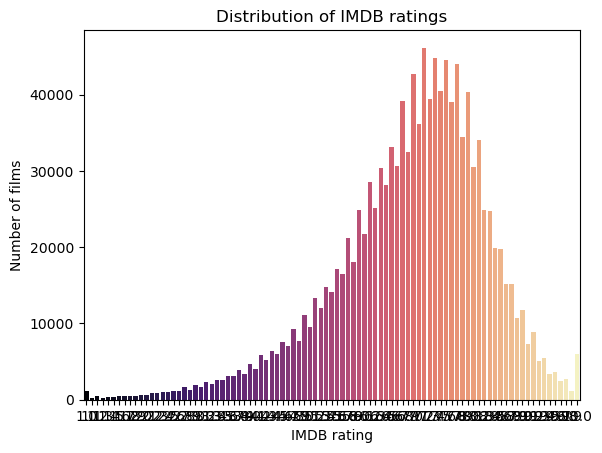

In [48]:
_ = sns.countplot(x='averageRating', data=imdb, palette="magma") \
   .set(title='Distribution of IMDB ratings', xlabel='IMDB rating', ylabel='Number of films')

In [49]:
C = imdb['averageRating'].mean()
m = imdb['numVotes'].min()
v = imdb['numVotes']
R = imdb['averageRating']

In [50]:
imdb['WR'] = (v / (v + m)) * R + (m / (v + m)) * C # Complete original dataset


To check if the weighted rating has worked, we display below the best rated movie. We observe that for an IMDB rating of 9/10, the weighted rating WR is better for movies with the most votes. We conclude that this weighted rating is more representative of a movie' success.

In [51]:
imdb[['originalTitle', 'averageRating', 'WR', 'numVotes']].sort_values('WR', ascending=False).head()

,originalTitle,averageRating,WR,numVotes
853340,Ozymandias,10.0,9.999918,185650
1000173,Unbreakable Souls,10.0,9.993245,2251
1023521,Angels Apocalypse,10.0,9.992627,2062
749029,Final Draft,10.0,9.978922,718
308511,Episode #1.9,10.0,9.975694,622


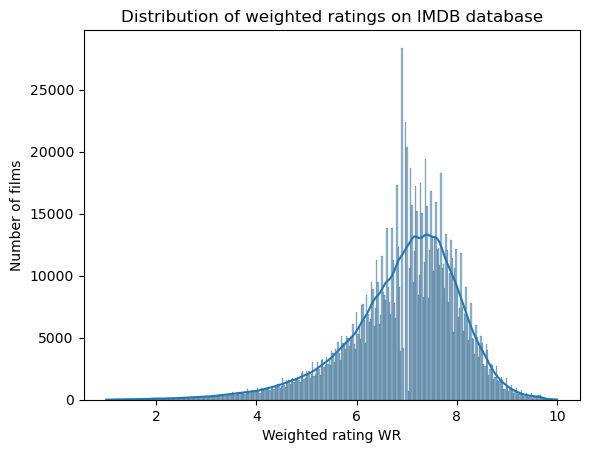

In [52]:
_ = sns.histplot(x='WR', data=imdb, kde=True) \
   .set(title='Distribution of weighted ratings on IMDB database', xlabel='Weighted rating WR', ylabel='Number of films')

### Merge IMDB database with movie database to have common features

We would like to merge the data from CMU movies and IMDB top 1000. Since we don't want to reduce the size of data, we would rather to an outer merge and fill missing values with NaN.

In [53]:
len((imdb['originalTitle'] + imdb['startYear'].astype(str)).unique()) / len(imdb)

0.9297141015371949

In [54]:
imdb.drop_duplicates(subset=['originalTitle', 'startYear'], inplace=True)

In [55]:
len((movies['name'] + movies['release_year'].astype(str)).unique()) / len(movies)

0.9977122863679182

In [56]:
# Remove duplicated movie with video game
movies.drop(movies[movies['wikipedia_id'] == 3184269].index, inplace=True)
# Fix duplicated movie with changing it release year to the correct one based on its wikipedia page
movies.loc[movies['wikipedia_id'] == 25357930, ['release_year']] = "2010"

In [57]:
movies.drop_duplicates(subset=['name', 'release_year'], inplace=True)

In [58]:
imdb.rename({'originalTitle': 'name', 'startYear': 'release_year'}, axis=1, inplace=True)

In [59]:
movies['release_year'] = movies['release_year'].replace('nan', np.nan).astype('float32')
movies['release_month'] = movies['release_month'].replace('nan', np.nan).astype('float32')
movies['release_day'] = movies['release_day'].replace('nan', np.nan).astype('float32')

In [60]:
movie_feature = movies.merge(imdb, on=['name', 'release_year'], how='left')

In [61]:
# Free memory
del imdb
del movies

In [62]:
def fill_NaN(df, column_left, column_right, column_name=None): # Updates missing data from left column with right column data
    if column_name is None:
        column_name = column_left
    df[column_name] = df[column_left].fillna(df[column_right])

In [63]:
fill_NaN(movie_feature, 'runtime', 'runtimeMinutes')
fill_NaN(movie_feature, 'genres_x', 'genres_y', 'genre')
movie_feature.drop(labels=['runtimeMinutes', 'genres_x', 'genres_y', 'primaryTitle', 'titleType', 'tconst', 'endYear'], axis=1, inplace=True)

In [64]:
movie_feature.columns

Index(['wikipedia_id', 'freebase_id', 'name', 'box_office_revenue', 'runtime',
       'languages', 'countries', 'release_year', 'release_month',
       'release_day', 'isAdult', 'averageRating', 'numVotes', 'directors',
       'writers', 'WR', 'genre'],
      dtype='object')

In [65]:
movie_feature.sample(3)

,wikipedia_id,freebase_id,name,box_office_revenue,runtime,languages,countries,release_year,release_month,release_day,isAdult,averageRating,numVotes,directors,writers,WR,genre
18052,21200382,/m/04znzp,Dick,NaN,94.0,[English],"[United States of America, France, Canada]",1999.0,7.0,23.0,0.0,6.2,20528.0,[Andrew Fleming],"[Andrew Fleming, Sheryl Longin]",6.200183,"[Parody, Female buddy film, Buddy film, Politi..."
43964,14909289,/m/03h16_0,To Rent Furnished,NaN,NaN,"[Silent film, English]",[United States of America],1915.0,11.0,12.0,NaN,NaN,NaN,NaN,NaN,NaN,"[Short Film, Silent film, Indie, Black-and-white]"
76269,27199326,/m/0bwlzr5,Killers of Kilimanjaro,NaN,91.0,[English],[United Kingdom],1959.0,10.0,NaN,0.0,5.4,383.0,[Richard Thorpe],"[Earl Felton, John Gilling, Cyril Hume, J.A. H...",5.420001,[Adventure]


In [66]:
movie_feature.describe()

,wikipedia_id,box_office_revenue,runtime,release_year,release_month,release_day,isAdult,averageRating,numVotes,WR
count,8.155500e+04,8.392000e+03,67052.000000,74720.000000,42596.000000,39305.000000,44031.000000,44031.000000,4.403100e+04,44031.000000
mean,1.740360e+07,4.799791e+07,93.715766,1977.460815,6.692201,15.651240,0.002566,6.195617,1.378128e+04,6.224498
std,1.098688e+07,1.122099e+08,60.342111,29.101585,3.483220,8.715734,0.050595,1.155310,7.286329e+04,1.102334
min,3.300000e+02,1.000000e+04,0.000000,1010.000000,1.000000,1.000000,0.000000,1.000000,5.000000e+00,1.131770
25%,7.320728e+06,2.075232e+06,80.000000,1956.000000,4.000000,8.000000,0.000000,5.600000,1.070000e+02,5.614247
50%,1.777503e+07,1.063551e+07,93.000000,1985.000000,7.000000,16.000000,0.000000,6.300000,5.160000e+02,6.317251
75%,2.714269e+07,4.073253e+07,108.000000,2004.000000,10.000000,23.000000,0.000000,7.000000,2.660500e+03,6.998635
max,3.750192e+07,2.782275e+09,5700.000000,2016.000000,12.000000,31.000000,1.000000,10.000000,2.667015e+06,9.467126


In [67]:
# print(f'There are {(imdb.shape[0]+movies.shape[0]) - movie_feature.shape[0]} common elements to both IMDB and Movie Corpus datasets. Knowing that IMDB includes {imdb.shape[0]} elements and Movie corpus includes {movies.shape[0]}.')


NameError: name 'imdb' is not defined

In [68]:
movie_feature.columns

Index(['wikipedia_id', 'freebase_id', 'name', 'box_office_revenue', 'runtime',
       'languages', 'countries', 'release_year', 'release_month',
       'release_day', 'isAdult', 'averageRating', 'numVotes', 'directors',
       'writers', 'WR', 'genre'],
      dtype='object')

[Text(0.5, 1.0, 'Distribution of weighted ratings on merged database'),
 Text(0.5, 0, 'Weighted rating WR'),
 Text(0, 0.5, 'Number of films')]

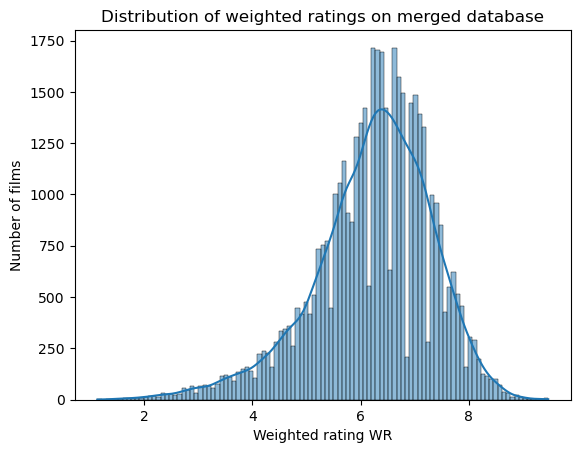

In [69]:
sns.histplot(x='WR', data=movie_feature, kde=True).set(title='Distribution of weighted ratings on merged database',xlabel='Weighted rating WR', ylabel='Number of films')


In [70]:
len((movie_feature['name'] + movie_feature['release_year'].astype(str)).unique()) / len(movie_feature)

1.0

### Fill missing budget data from imdb budget dataset

In [71]:
imdb_budget.sample(5)

,Movie,Year,IMDb,Rating,Runtime,Genre,Release Date,Production Budget,Domestic Gross,Worldwide Gross
886,Hotel for Dogs,2009,5.4,PG,100,"Comedy, Family","Jan 16, 2009",35000000,73178547,122357172
1613,Hitman,2007,6.3,R,100,"Action, Crime, Thriller","Nov 21, 2007",24000000,39687694,99135571
1488,Wall Street,1987,7.4,R,126,"Crime, Drama","Dec 11, 1987",16500000,43848100,43848100
123,X-Men: Days of Future Past,2014,8.0,PG-13,132,"Action, Adventure, Sci-Fi","May 21, 2014",200000000,233921534,747862775
978,Kangaroo Jack,2003,4.4,PG,89,"Action, Adventure, Comedy","Jan 17, 2003",60000000,66723216,90558582


In [72]:
imdb_budget['Release Date'] = imdb_budget['Release Date'].astype('str') # Convert to string all dates
release_date = pd.DataFrame(pd.to_datetime(imdb_budget['Release Date']).apply(lambda x: [x.year, x.month, x.day]).tolist(), columns=['release_year','release_month','release_day'])
imdb_budget[['release_year','release_month','release_day']] = release_date

In [73]:
imdb_budget['release_year'] = imdb_budget['release_year'].astype('float32')
imdb_budget['release_month'] = imdb_budget['release_month'].astype('float32')
imdb_budget['release_day'] = imdb_budget['release_day'].astype('float32')

In [74]:
imdb_budget.drop(['Year', 'Release Date'], axis=1, inplace=True)
imdb_budget.rename({'Movie': 'name', 'Genre': 'genres'}, axis=1, inplace=True)
imdb_budget.columns

Index(['name', 'IMDb', 'Rating', 'Runtime', 'genres', 'Production Budget',
       'Domestic Gross', 'Worldwide Gross', 'release_year', 'release_month',
       'release_day'],
      dtype='object')

In [75]:
imdb_budget['genres'] = imdb_budget['genres'].apply(lambda el: el.split(', '))

In [76]:
imdb_budget.describe()

,IMDb,Runtime,Production Budget,Domestic Gross,Worldwide Gross,release_year,release_month,release_day
count,3828.000000,3828.000000,3.828000e+03,3.828000e+03,3.828000e+03,3828.000000,3828.000000,3828.000000
mean,6.459013,109.940439,4.030960e+07,5.559021e+07,1.206910e+08,2003.593994,7.322100,15.891066
std,0.996623,20.219674,4.480927e+07,7.403263e+07,1.993646e+08,12.767752,3.378486,8.437509
min,1.500000,63.000000,7.000000e+03,0.000000e+00,0.000000e+00,1925.000000,1.000000,1.000000
25%,5.900000,96.000000,1.100000e+07,1.180967e+07,1.690363e+07,1999.000000,5.000000,9.000000
50%,6.500000,106.000000,2.500000e+07,3.225471e+07,5.077617e+07,2006.000000,8.000000,16.000000
75%,7.100000,120.000000,5.000000e+07,6.848642e+07,1.388776e+08,2013.000000,10.000000,23.000000
max,9.300000,271.000000,4.000000e+08,8.583730e+08,2.797801e+09,2020.000000,12.000000,31.000000


In [77]:
len((movie_feature['name'] + str(movie_feature['release_year'])).unique()) / len(movie_feature)

0.9254858684323463

In [78]:
imdb_budget.columns

Index(['name', 'IMDb', 'Rating', 'Runtime', 'genres', 'Production Budget',
       'Domestic Gross', 'Worldwide Gross', 'release_year', 'release_month',
       'release_day'],
      dtype='object')

In [79]:
movie_feature.columns

Index(['wikipedia_id', 'freebase_id', 'name', 'box_office_revenue', 'runtime',
       'languages', 'countries', 'release_year', 'release_month',
       'release_day', 'isAdult', 'averageRating', 'numVotes', 'directors',
       'writers', 'WR', 'genre'],
      dtype='object')

In [80]:
movie_feature_with_budget = movie_feature.merge(imdb_budget, on=['name', 'release_year'], how='outer')

In [81]:
movie_feature_with_budget.columns

Index(['wikipedia_id', 'freebase_id', 'name', 'box_office_revenue', 'runtime',
       'languages', 'countries', 'release_year', 'release_month_x',
       'release_day_x', 'isAdult', 'averageRating', 'numVotes', 'directors',
       'writers', 'WR', 'genre', 'IMDb', 'Rating', 'Runtime', 'genres',
       'Production Budget', 'Domestic Gross', 'Worldwide Gross',
       'release_month_y', 'release_day_y'],
      dtype='object')

In [82]:
fill_NaN(movie_feature_with_budget,'genre','genres','genre')
fill_NaN(movie_feature_with_budget,'release_day_x','release_day_y','release_day')
fill_NaN(movie_feature_with_budget,'release_month_x','release_month_y','release_month')
fill_NaN(movie_feature_with_budget,'runtime','Runtime')

### Investigate the gross difference between the original and the imdb budget datasets

<AxesSubplot:title={'center':'Distribution of the difference of the total worldwide gross data from the two datasets'}, ylabel='Frequency'>

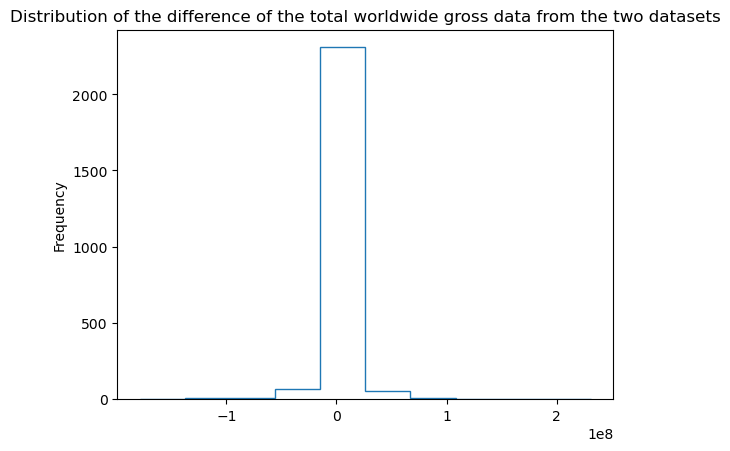

In [83]:
(movie_feature_with_budget['box_office_revenue'] - movie_feature_with_budget['Worldwide Gross']).plot(kind='hist', histtype='step', title='Distribution of the difference of the total worldwide gross data from the two datasets')

<AxesSubplot:title={'center':'Distribution of the percentage in difference of the total worldwide gross data from the two datasets'}, ylabel='Frequency'>

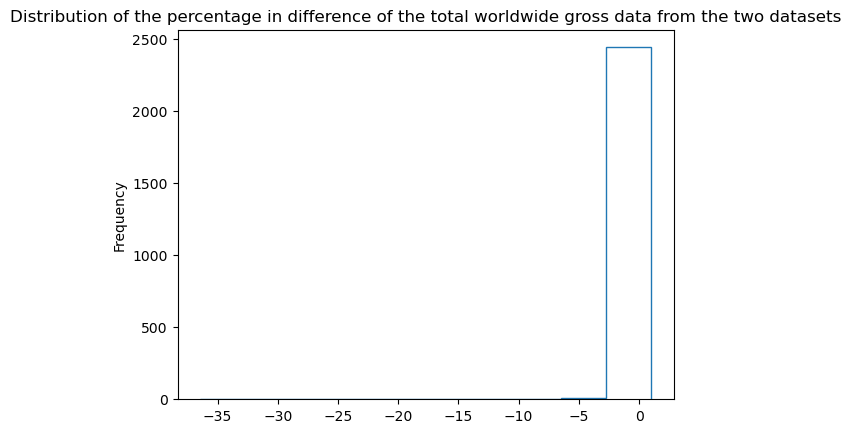

In [84]:
((movie_feature_with_budget['box_office_revenue'] - movie_feature_with_budget['Worldwide Gross']) / movie_feature_with_budget['box_office_revenue']).plot(kind='hist', histtype='step', title='Distribution of the percentage in difference of the total worldwide gross data from the two datasets')

In [85]:
movie_feature_with_budget_differences = movie_feature_with_budget.copy()
movie_feature_with_budget_differences['gross_difference'] = np.abs(movie_feature_with_budget_differences['box_office_revenue'] - movie_feature_with_budget_differences['Worldwide Gross'])
movie_feature_with_budget_differences['gross_difference%'] = ((np.abs(movie_feature_with_budget['box_office_revenue'] - movie_feature_with_budget['Worldwide Gross']) / movie_feature_with_budget['box_office_revenue']) * 100).round(2)

In [86]:
# Difference between the total worldwide gross data from the two datasets
movie_feature_with_budget_differences \
    [(movie_feature_with_budget_differences['gross_difference'] != 0) & (~movie_feature_with_budget_differences['gross_difference'].isna())] \
    .sort_values('gross_difference%', ascending=False) \
    [['name', 'box_office_revenue', 'Worldwide Gross', 'gross_difference', 'gross_difference%']]

,name,box_office_revenue,Worldwide Gross,gross_difference,gross_difference%
1611,The Son of No One,30680.0,1148578.0,1117898.0,3643.74
10379,Restless,163265.0,2772511.0,2609246.0,1598.17
3307,Welcome to Collinwood,336620.0,4606284.0,4269664.0,1268.39
30129,Margaret,46495.0,623292.0,576797.0,1240.56
4126,The Wizard of Oz,3017000.0,34949482.0,31932482.0,1058.42
...,...,...,...,...,...
56979,Click,237681299.0,237685089.0,3790.0,0.00
57636,G-Force,292810686.0,292817841.0,7155.0,0.00
12989,What Women Want,374111707.0,374105123.0,6584.0,0.00
58624,Butch Cassidy and the Sundance Kid,102308889.0,102310653.0,1764.0,0.00


In [87]:
# Percentage differences between the gross data from the two datasets
movie_feature_with_budget_differences.describe(percentiles=[.25, .5, .75, .8, .9, .95])[['gross_difference%']]

,gross_difference%
count,2464.000000
mean,16.458888
std,101.443043
min,0.000000
25%,0.020000
50%,0.695000
75%,5.455000
80%,9.924000
90%,34.167000
95%,62.882000


In [88]:
movie_feature_with_budget_differences[movie_feature_with_budget_differences['gross_difference'] == 0].shape[0] / movie_feature_with_budget_differences['gross_difference%'].notna().sum()

0.15868506493506493

In [89]:
movie_feature_with_budget_differences[
    (movie_feature_with_budget_differences['name'] == 'The Son of No One') |
    (movie_feature_with_budget_differences['name'] == 'Restless') |
    (movie_feature_with_budget_differences['name'] == 'Welcome to Collinwood')
][[
    'name', 'box_office_revenue', 'Worldwide Gross'
]]

,name,box_office_revenue,Worldwide Gross
1611,The Son of No One,30680.0,1148578.0
3307,Welcome to Collinwood,336620.0,4606284.0
10379,Restless,163265.0,2772511.0
18706,Restless,NaN,NaN
31576,Restless,NaN,NaN


In [90]:
# gross_difference = box_office_revenue - Worldwide Gross
print((movie_feature_with_budget_differences['box_office_revenue'] - movie_feature_with_budget_differences['Worldwide Gross'] > 0).sum())
print((movie_feature_with_budget_differences['box_office_revenue'] - movie_feature_with_budget_differences['Worldwide Gross'] < 0).sum())
print((movie_feature_with_budget_differences['box_office_revenue'] - movie_feature_with_budget_differences['Worldwide Gross'] == 0).sum())
(movie_feature_with_budget_differences['box_office_revenue'] - movie_feature_with_budget_differences['Worldwide Gross']).describe()

1012
1061
391


count    2.464000e+03
mean     4.148700e+05
std      1.570988e+07
min     -1.785914e+08
25%     -6.153875e+05
50%      0.000000e+00
75%      1.997022e+05
max      2.310745e+08
dtype: float64

We want to fill the missing data from the imdb budget dataset. For this purpose we are comparing the difference between the CMU, imdb top 1000, and imdb budget data. We have the:
 
 * `box_office_revenue` - from CMU with 8401 values /total gross/
 * `Gross` - from imdb top 1000 with 831 values /total gross in US and Canada/
 * `Domestic Gross` - from imdb budget with 3841 values /total gross in US and Canada/
 * `Worldwide Gross` - from imdb budget with 3841 values /total gross/

We would only consider the total worldwide gross since we are investigating movies from the whole world. The information for it is contained in the `box_office_revenue` and `Worldwide Gross`. Only around 20% of the values for the total gross are the same. Also, we know that the other data in `box_office_revenue` is not bigger or smaller than the `Worldwide Gross` for all records. So we can conclude that `box_office_revenue` and `Worldwide Gross` are not connected.

Based on this, we cannot combine the data from the both datasets and we would prefer using the data from the imdb budget dataset because it contains information about the budget of the movie and the data inside seams more accurate based on the comparison of a subset of it with Wikipedia data.

In [91]:
movie_feature_with_budget.columns

Index(['wikipedia_id', 'freebase_id', 'name', 'box_office_revenue', 'runtime',
       'languages', 'countries', 'release_year', 'release_month_x',
       'release_day_x', 'isAdult', 'averageRating', 'numVotes', 'directors',
       'writers', 'WR', 'genre', 'IMDb', 'Rating', 'Runtime', 'genres',
       'Production Budget', 'Domestic Gross', 'Worldwide Gross',
       'release_month_y', 'release_day_y', 'release_day', 'release_month'],
      dtype='object')

In [92]:
movie_feature_with_budget.columns

Index(['wikipedia_id', 'freebase_id', 'name', 'box_office_revenue', 'runtime',
       'languages', 'countries', 'release_year', 'release_month_x',
       'release_day_x', 'isAdult', 'averageRating', 'numVotes', 'directors',
       'writers', 'WR', 'genre', 'IMDb', 'Rating', 'Runtime', 'genres',
       'Production Budget', 'Domestic Gross', 'Worldwide Gross',
       'release_month_y', 'release_day_y', 'release_day', 'release_month'],
      dtype='object')

In [93]:
# Remove merged extra columns 
movie_feature_with_budget.drop([
    'Worldwide Gross', 'Domestic Gross', 'Rating', 'Runtime', 'IMDb', 'release_month_x', 'release_month_y',
    'release_day_x', 'release_day_y', 'genres'
], axis=1, inplace=True)

# Rename gross column
movie_feature_with_budget.rename({'box_office_revenue': 'total_gross'}, axis=1, inplace=True)

# Compute profit as success indicator
movie_feature_with_budget['profit'] = movie_feature_with_budget['total_gross'] - movie_feature_with_budget['Production Budget']

In [94]:
movie_feature_with_budget.columns

Index(['wikipedia_id', 'freebase_id', 'name', 'total_gross', 'runtime',
       'languages', 'countries', 'release_year', 'isAdult', 'averageRating',
       'numVotes', 'directors', 'writers', 'WR', 'genre', 'Production Budget',
       'release_day', 'release_month', 'profit'],
      dtype='object')

In [95]:
movie_feature_with_budget.describe()

,wikipedia_id,total_gross,runtime,release_year,isAdult,averageRating,numVotes,WR,Production Budget,release_day,release_month,profit
count,8.155500e+04,8.392000e+03,68104.000000,75770.000000,44031.000000,44031.000000,4.403100e+04,44031.000000,3.828000e+03,40527.000000,43783.000000,2.464000e+03
mean,1.740360e+07,4.799791e+07,93.965487,1977.970337,0.002566,6.195617,1.378128e+04,6.224498,4.030960e+07,15.658129,6.707717,7.208180e+07
std,1.098688e+07,1.122099e+08,59.949382,29.228281,0.050595,1.155310,7.286329e+04,1.102334,4.480927e+07,8.708538,3.483055,1.442546e+08
min,3.300000e+02,1.000000e+04,0.000000,1010.000000,0.000000,1.000000,5.000000e+00,1.131770,7.000000e+03,1.000000,1.000000,-1.110072e+08
25%,7.320728e+06,2.075232e+06,80.000000,1956.000000,0.000000,5.600000,1.070000e+02,5.614247,1.100000e+07,8.000000,4.000000,4.951632e+05
50%,1.777503e+07,1.063551e+07,93.000000,1986.000000,0.000000,6.300000,5.160000e+02,6.317251,2.500000e+07,16.000000,7.000000,2.414130e+07
75%,2.714269e+07,4.073253e+07,108.000000,2004.000000,0.000000,7.000000,2.660500e+03,6.998635,5.000000e+07,23.000000,10.000000,8.700518e+07
max,3.750192e+07,2.782275e+09,5700.000000,2020.000000,1.000000,10.000000,2.667015e+06,9.467126,4.000000e+08,31.000000,12.000000,2.545275e+09


In [96]:
movie_feature_with_budget.head(5)

,wikipedia_id,freebase_id,name,total_gross,runtime,languages,countries,release_year,isAdult,averageRating,numVotes,directors,writers,WR,genre,Production Budget,release_day,release_month,profit
0,975900.0,/m/03vyhn,Ghosts of Mars,14010832.0,98.0,[English],[United States of America],2001.0,0.0,4.9,55353.0,[John Carpenter],"[Larry Sulkis, John Carpenter]",4.900185,"[Thriller, Science Fiction, Horror, Adventure,...",NaN,24.0,8.0,NaN
1,3196793.0,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,NaN,95.0,[English],[United States of America],2000.0,NaN,NaN,NaN,NaN,NaN,NaN,"[Mystery, Biographical film, Drama, Crime Drama]",NaN,16.0,2.0,NaN
2,28463795.0,/m/0crgdbh,Brun bitter,NaN,83.0,[Norwegian],[Norway],1988.0,0.0,5.7,40.0,[Sølve Skagen],"[Sølve Skagen, Gunnar Staalesen]",5.839121,"[Crime Fiction, Drama]",NaN,NaN,NaN,NaN
3,9363483.0,/m/0285_cd,White Of The Eye,NaN,110.0,[English],[United Kingdom],1987.0,NaN,NaN,NaN,NaN,NaN,NaN,"[Thriller, Erotic thriller, Psychological thri...",NaN,NaN,NaN,NaN
4,261236.0,/m/01mrr1,A Woman in Flames,NaN,106.0,[German],[Germany],1983.0,NaN,NaN,NaN,NaN,NaN,NaN,[Drama],NaN,NaN,NaN,NaN


## Account for inflation: 

As our movie database has movies dating back to 1921, we need to adjust the budgets and profits through an inflation rate.

Source: https://inflationdata.com/Inflation/Inflation/DecadeInflation.asp

In [97]:
# Create dictionary of cumulative inflation rate per decade since 1913 in the US:
inflation_rates = [92.86, 4.82, -18.6, 68.57, 24.58, 28.23, 103.45, 64.41, 33.47, 28.31, 19.38, 1.27]
inflation_rates = [x / 100 + 1 for x in inflation_rates]
decades = list(np.linspace(1913,2023,len(inflation_rates)))
inflation_dic = dict(map(lambda i,j : (i,j) , decades, inflation_rates))

In [98]:
df = movie_feature_with_budget.copy()

In [99]:
# Initialisation
df['profit_modified'] = df['profit']
df['total_gross_modified'] = df['total_gross']
df['budget_modified'] = df['Production Budget']

In [100]:
for k in range(len(decades)-1): # For each decade
    year_before = decades[k]
    year = decades[k+1]
    inflation_rate = inflation_dic[year_before]
    
    decade_df = df[(df['release_year']<year) & (df['release_year']>year_before)] # decade mask
    
    idx = decade_df.index.tolist()

    # Create new column with prices modified by interest rate
    df.loc[idx, 'profit_modified'] = decade_df['profit'] * inflation_rate
    df.loc[idx, 'total_gross_modified'] = decade_df['total_gross'] * inflation_rate
    df.loc[idx, 'budget_modified'] = decade_df['Production Budget'] * inflation_rate

In [101]:
movie_feature_with_budget = df.copy()

In [102]:
movie_feature_with_budget.head(2)

,wikipedia_id,freebase_id,name,total_gross,runtime,languages,countries,release_year,isAdult,averageRating,...,writers,WR,genre,Production Budget,release_day,release_month,profit,profit_modified,total_gross_modified,budget_modified
0,975900.0,/m/03vyhn,Ghosts of Mars,14010832.0,98.0,[English],[United States of America],2001.0,0.0,4.9,...,"[Larry Sulkis, John Carpenter]",4.900185,"[Thriller, Science Fiction, Horror, Adventure,...",NaN,24.0,8.0,NaN,NaN,1.870026e+07,NaN
1,3196793.0,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,NaN,95.0,[English],[United States of America],2000.0,NaN,NaN,...,NaN,NaN,"[Mystery, Biographical film, Drama, Crime Drama]",NaN,16.0,2.0,NaN,NaN,NaN,NaN


In [103]:
# Delete the columns for budget which are not modified by inflation rate: 
movie_feature_with_budget.drop(['total_gross','profit', 'Production Budget'], axis=1, inplace=True)

### Wikipedia pageviews

In [104]:
wikipedia_pageviews.sample(5)

,name,pageviews
37219,Mixed and Fixed,20.363883
56472,The Combination,995.965086
63112,The Reluctant Astronaut,1581.873188
58038,The Floorwalker,419.434124
46582,Ricky Rapper and the Bicycle Thief,NaN


In [105]:
wikipedia_pageviews.describe()

,pageviews
count,6.758400e+04
mean,3.822596e+03
std,2.650207e+04
min,0.000000e+00
25%,4.189995e+01
50%,2.226739e+02
75%,1.155286e+03
max,5.154324e+06


In [106]:
movie_feature_with_budget_and_wikipedia_pageviews = pd.merge(movie_feature_with_budget, wikipedia_pageviews, on='name', how='left')

# Free memory
del movie_feature_with_budget
del wikipedia_pageviews

In [107]:
movie_feature_with_budget_and_wikipedia_pageviews.describe()

,wikipedia_id,runtime,release_year,isAdult,averageRating,numVotes,WR,release_day,release_month,profit_modified,total_gross_modified,budget_modified,pageviews
count,8.155500e+04,68104.000000,75770.000000,44031.000000,44031.000000,4.403100e+04,44031.000000,40527.000000,43783.000000,2.464000e+03,8.392000e+03,3.828000e+03,7.330000e+04
mean,1.740360e+07,93.965487,1977.970337,0.002566,6.195617,1.378128e+04,6.224498,15.658129,6.707717,9.605612e+07,6.483874e+07,5.092346e+07,5.087095e+03
std,1.098688e+07,59.949382,29.228281,0.050595,1.155310,7.286329e+04,1.102334,8.708538,3.483055,1.897343e+08,1.487117e+08,5.505716e+07,5.753066e+04
min,3.300000e+02,0.000000,1010.000000,0.000000,1.000000,5.000000e+00,1.131770,1.000000,1.000000,-1.424334e+08,1.138400e+04,8.981700e+03,0.000000e+00
25%,7.320728e+06,80.000000,1956.000000,0.000000,5.600000,1.070000e+02,5.614247,8.000000,4.000000,6.762006e+05,2.803050e+06,1.411410e+07,4.350988e+01
50%,1.777503e+07,93.000000,1986.000000,0.000000,6.300000,5.160000e+02,6.317251,16.000000,7.000000,3.261206e+07,1.456574e+07,3.255200e+07,2.368342e+02
75%,2.714269e+07,108.000000,2004.000000,0.000000,7.000000,2.660500e+03,6.998635,23.000000,10.000000,1.156132e+08,5.778973e+07,6.673500e+07,1.277118e+03
max,3.750192e+07,5700.000000,2020.000000,1.000000,10.000000,2.667015e+06,9.467126,31.000000,12.000000,3.265843e+09,3.569937e+09,4.862949e+08,5.154324e+06


### Prepare `df_all`

In [108]:
# For simplicity of use, we rename the dataframe
df_all = movie_feature_with_budget_and_wikipedia_pageviews

#### Deal with NaN

In [109]:
fill_na_with_list(df_all, 'languages')
fill_na_with_list(df_all, 'countries')
fill_na_with_list(df_all, 'genre')
fill_na_with_list(df_all, 'directors')
fill_na_with_list(df_all, 'writers')

#### Remove irrelevant columns

In [110]:
df_all.drop(['wikipedia_id', 'averageRating', 'numVotes'], axis=1, inplace=True)

#### One hot encoding for list values

In [111]:
df_all_ohe = df_all.copy()

In [112]:
def one_hot_encoding_list(df, column_name, top_count):
    top = pd.Series([el for _list in df[column_name] for el in _list]).value_counts()[:top_count].index
    df[column_name] = df[column_name].apply(lambda _list: [el if el in top else 'Other' for el in _list])
    result = df.join(pd.get_dummies(df[column_name].apply(pd.Series).stack(), prefix=column_name).groupby(level=0).max())
    result.fillna({f'{column_name}_{el}': 0 for el in list(top) + ['Other']}, inplace=True)
    result.drop([column_name], axis=1, inplace=True)
    return result

In [113]:
def one_hot_encoding(df, column_name, top_count):
    top = df[column_name].value_counts()[:top_count].index
    df[column_name] = df[column_name].apply(lambda el: el if el in top else 'Other')
    result = df.join(pd.get_dummies(df[column_name], prefix=column_name).groupby(level=0).max())
    result.drop([column_name], axis=1, inplace=True)
    return result

In [114]:
df_all_ohe = one_hot_encoding_list(df_all_ohe, 'genre', 25)
df_all_ohe = one_hot_encoding_list(df_all_ohe, 'languages', 15)
df_all_ohe = one_hot_encoding_list(df_all_ohe, 'countries', 15)
df_all_ohe = one_hot_encoding_list(df_all_ohe, 'directors', 30)
df_all_ohe = one_hot_encoding_list(df_all_ohe, 'writers', 30)

/var/folders/m_/fhwnh1jn04qgx3nmt22_5h340000gn/T/ipykernel_72106/142190017.py:4: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  result = df.join(pd.get_dummies(df[column_name].apply(pd.Series).stack(), prefix=column_name).groupby(level=0).max())


KeyboardInterrupt: 

#### Expand the list values

In [ ]:
df_all_expanded = df_all.copy()

In [ ]:
df_all_expanded = df_all_expanded.explode('genre')
df_all_expanded = df_all_expanded.explode('languages')
df_all_expanded = df_all_expanded.explode('countries')
df_all_expanded = df_all_expanded.explode('directors')
df_all_expanded = df_all_expanded.explode('writers')

In [ ]:
df_all_expanded.sample(5)

,freebase_id,name,runtime,languages,countries,release_year,isAdult,directors,writers,WR,genre,release_day,release_month,profit_modified,total_gross_modified,budget_modified,pageviews
75741,/m/0j65b5c,Gosainbaganer Bhoot,NaN,NaN,NaN,2011.0,NaN,NaN,NaN,NaN,Fantasy,30.0,12.0,NaN,NaN,NaN,167.383152
11046,/m/02q9n_9,Il Generale della Rovere,138.0,German,France,1959.0,NaN,NaN,NaN,NaN,Crime Fiction,NaN,NaN,NaN,NaN,NaN,13.632246
18141,/m/0c019sm,Gaayam,140.0,Telugu,India,1993.0,0.0,Ram Gopal Varma,Krishna Murali Posani,7.494420,Drama,NaN,NaN,NaN,NaN,NaN,5561.857955
21806,/m/04j0z0w,Paarai,140.0,Tamil,India,2001.0,NaN,NaN,NaN,NaN,Romantic drama,NaN,NaN,NaN,NaN,NaN,23.477273
58640,/m/02q_tth,Black Cadillac,92.0,English,United States of America,2003.0,0.0,John Murlowski,John Murlowski,5.801829,Psychological thriller,NaN,NaN,NaN,NaN,NaN,55.098732


For the final dataset obtained, we gather data from 4 different sources. In order to not restrain ourselves to only common features and end up with a smaller dataset, we made the choice of outer merges filled with NaN. Indeed, if we had taken inner merge of all datasets, it might be that our final dataset is both small and not badly representative of the population. 

Having NaN values has however some consequences on our data analysis. It might be that the NaN are not fully random, for instance, runtime for Crime movies are all missing values while we have the runtime for all Comedies. This should ideally be investigated further to check the NaN are indeed random. In the framework of this milestone, the choice was to focus on other tasks. We will thus assume randomness of NaN values.



### Save dataframe to avoid running pre-processing

In [ ]:
df_all.to_csv('./handled_data/dataframes/df_all.csv',encoding='utf-8')
df_all_expanded.to_csv('./handled_data/dataframes/df_all_expanded.csv',encoding='utf-8')
df_all_ohe.to_csv('./handled_data/dataframes/df_all_ohe.csv',encoding='utf-8')
characters.to_csv('./handled_data/dataframes/characters.csv',encoding='utf-8')

### Read processed dataframe to avoid running pre-processing

In [ ]:
import ast
df_all = pd.read_csv('./handled_data/dataframes/df_all.csv',encoding='utf-8',index_col=0, na_values='',converters={column :ast.literal_eval for column in ['languages', 'countries', 'directors', 'writers', 'genre']})
df_all_expanded = pd.read_csv('./handled_data/dataframes/df_all_expanded.csv',encoding='utf-8',index_col=0)
df_all_ohe = pd.read_csv('./handled_data/dataframes/df_all_ohe.csv',encoding='utf-8',index_col=0)
characters = pd.read_csv('./handled_data/dataframes/characters.csv',encoding='utf-8',index_col=0)

/opt/anaconda3/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3457: DtypeWarning: Columns (1) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


# Exploratory Data Analysis

## Success indicators

Success of a movie can be very subjective. We thus need to diversify our definitions of success to have a holistic view of our dataset. The following success indicators are considered: 
- How well a movie is received: 
    IMDB ratings which should be weighted by the number of votes
- How profitable a movie is: 
    Overall gross revenue of the movie OR profit = gross revenue - budget spent
- How long a movie will last in time: 
    Number of connection to the movie wikipedia page


## Explore data

Looking at the impacts of features on eachother by drawing a correlation heatmap

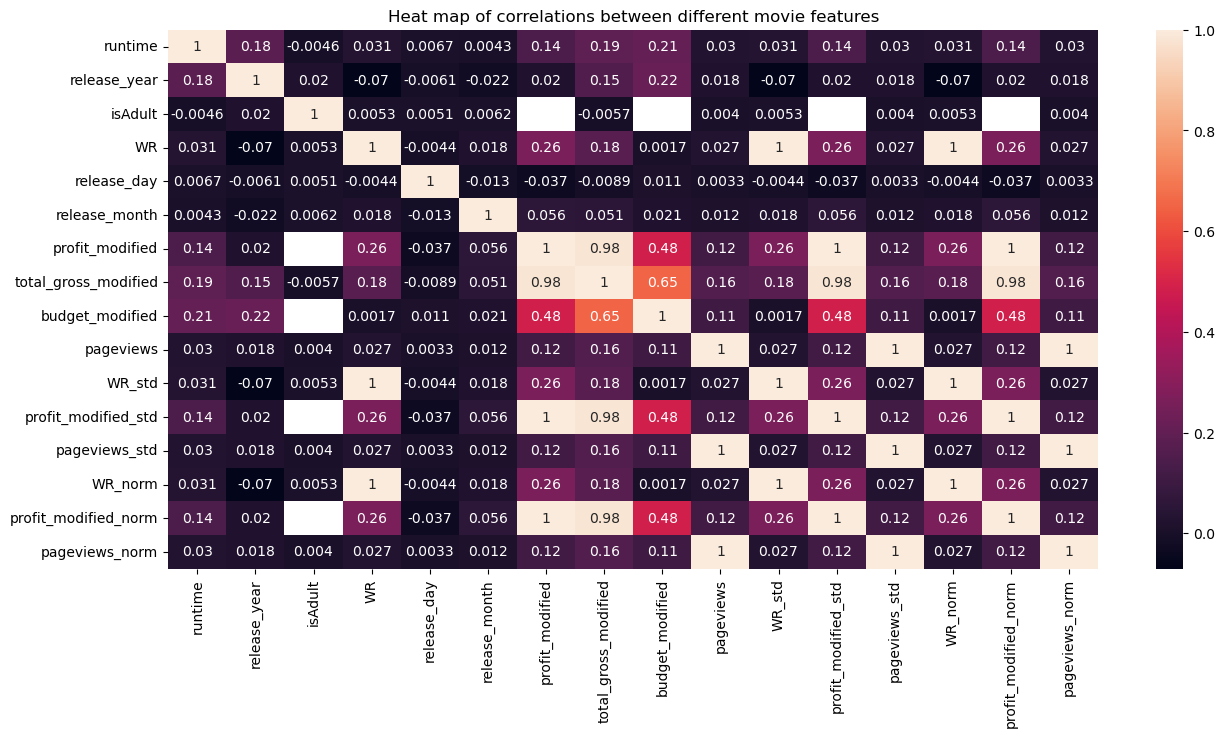

In [ ]:
fig, ax = plt.subplots(figsize=(15,7))
sns.heatmap(df_all.corr(), annot=True, ax=ax).set(title='Heat map of correlations between different movie features');


Interesting correlations: 
Our different success indicators are not too correlated (WR, profit_modified, pageviews) 

### Creation of unique success score

In order to investigate the relation between movie features and success, it would be practical to have a unique movie success score. Seeing how the weighted ratings, the profit, and the number of pageviews are uncorrelated, a movie that is successful in time (high pageviews) might however not be the most profitable (high profit), same thing for IMDB rating. 

In [ ]:
df_all.columns

Index(['freebase_id', 'name', 'runtime', 'languages', 'countries',
       'release_year', 'isAdult', 'directors', 'writers', 'WR', 'genre',
       'release_day', 'release_month', 'profit_modified',
       'total_gross_modified', 'budget_modified', 'pageviews', 'WR_std',
       'profit_modified_std', 'pageviews_std', 'WR_norm',
       'profit_modified_norm', 'pageviews_norm'],
      dtype='object')

In [ ]:
# We standardise each success feature
df_all['WR_std'] = (df_all['WR'] - df_all['WR'].mean())/df_all['WR'].std()
df_all['profit_modified_std'] = (df_all['profit_modified'] - df_all['profit_modified'].mean())/df_all['profit_modified'].std()
df_all['pageviews_std'] = (df_all['pageviews'] - df_all['pageviews'].mean())/df_all['pageviews'].std()
df_all['total_gross_modified_std'] = (df_all['total_gross_modified'] - df_all['total_gross_modified'].mean())/df_all['total_gross_modified'].std()



In [ ]:
# We L2 normalise each success feature
df_all['WR_norm'] = df_all['WR'] / np.sqrt(np.square(df_all['WR']).sum(axis=0))
df_all['profit_modified_norm'] = df_all['profit_modified'] / np.sqrt(np.square(df_all['profit_modified']).sum(axis=0))
df_all['pageviews_norm'] = df_all['pageviews'] / np.sqrt(np.square(df_all['pageviews']).sum(axis=0))
df_all['total_gross_modified_norm'] = df_all['total_gross_modified'] / np.sqrt(np.square(df_all['total_gross_modified']).sum(axis=0))



In [ ]:
df_all[['WR_std','profit_modified_std','pageviews_std','WR_norm','profit_modified_norm','pageviews_norm']].describe()

,WR_std,profit_modified_std,pageviews_std,WR_norm,profit_modified_norm,pageviews_norm
count,4.403100e+04,2.464000e+03,7.330000e+04,44031.000000,2464.000000,73300.000000
mean,-4.862001e-17,-2.553648e-16,1.549868e-15,0.004693,0.009101,0.000325
std,1.000000e+00,1.000000e+00,1.000000e+00,0.000831,0.017976,0.003679
min,-4.619948e+00,-1.256965e+00,-8.842407e-02,0.000853,-0.013495,0.000000
25%,-5.535986e-01,-5.027024e-01,-8.766778e-02,0.004233,0.000064,0.000003
50%,8.414206e-02,-3.343836e-01,-8.430741e-02,0.004763,0.003090,0.000015
75%,7.022702e-01,1.030759e-01,-6.622515e-02,0.005276,0.010954,0.000082
max,2.941601e+00,1.670645e+01,8.950422e+01,0.007137,0.309422,0.329634


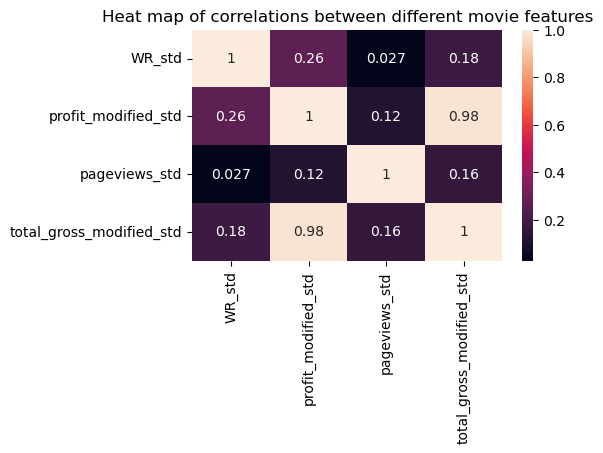

In [ ]:
fig, ax = plt.subplots(figsize=(5,3))
sns.heatmap(df_all[['WR_std','profit_modified_std','pageviews_std','total_gross_modified_std']].corr(), annot=True, ax=ax).set(title='Heat map of correlations between different movie features');

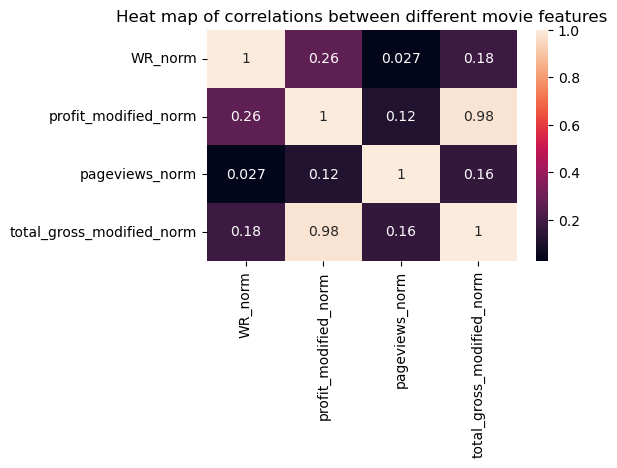

In [ ]:
fig, ax = plt.subplots(figsize=(5,3))
sns.heatmap(df_all[['WR_norm','profit_modified_norm','pageviews_norm','total_gross_modified_norm']].corr(), annot=True, ax=ax).set(title='Heat map of correlations between different movie features');

There is still no strong correlations.

### Impact of release date on success

To assess the impact of release date on success, we need to use the information on 'release_month' for each movie and need to choose a feature for success which can be either the IMDB weighted rating 'WR' or the gross revenue.

In [ ]:
print(f"Out of {df_all.shape[0]} movies in out dataset, we have the release month information for {df_all['release_month'].count()} movies which is a big enough dataset to be representative.")

Out of 82605 movies in out dataset, we have the release month information for 43783 movies which is a big enough dataset to be representative.


In [ ]:
df_release = df_all.dropna(how='all', subset=['release_month']) # Remove NaN months

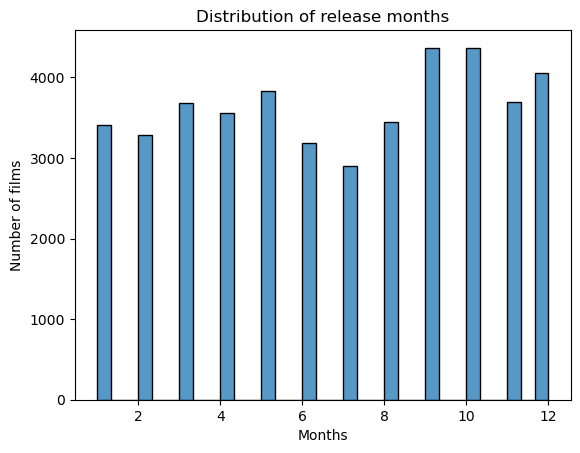

In [ ]:
sns.histplot(x='release_month', data = df_release).set(title='Distribution of release months',xlabel='Months', ylabel='Number of films');

From the plot above, we can see that the distribution of release months is fairly homogeneous accross the data which allows to investigate success accross different release months.

In [ ]:
df_release=df_release.sort_values(by='release_month', ascending=True)

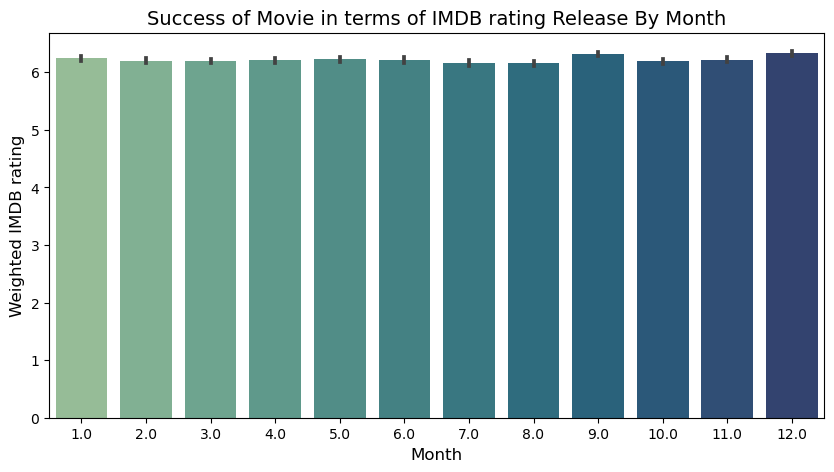

In [ ]:
# Plot
plt.figure(figsize=(10,5));
ax = sns.barplot(x="release_month", y="WR",data=df_release,palette='crest');
plt.xlabel('Month', fontsize=12)
plt.ylabel('Weighted IMDB rating', fontsize=12)
plt.title('Success of Movie in terms of IMDB rating Release By Month', fontsize=14);

Text(0.5, 1.0, 'Success in terms of revenue of Movie Release By Month')

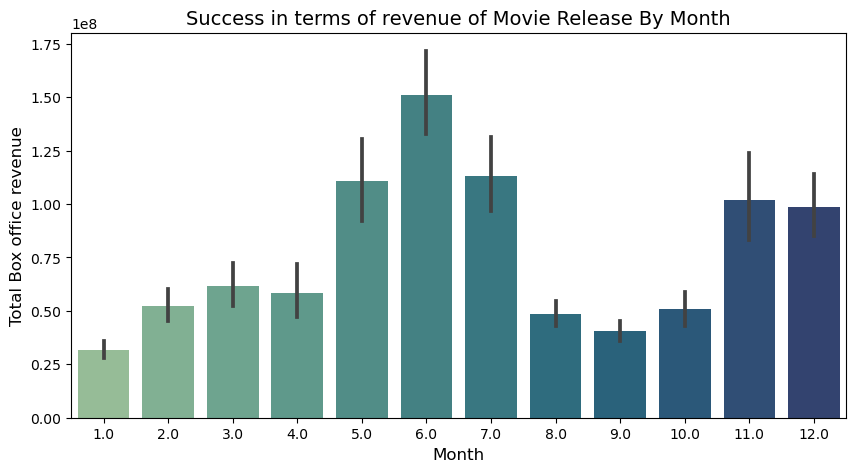

In [ ]:
# Plot
plt.figure(figsize=(10,5))
ax = sns.barplot(x="release_month", y="total_gross_modified",data=df_release,palette='crest')
plt.xlabel('Month', fontsize=12)
plt.ylabel('Total Box office revenue', fontsize=12)
plt.title('Success in terms of revenue of Movie Release By Month', fontsize=14)

As we can see from the results above, the movie weighted ratings are not at all influenced by the release period. However, the gross revenue is. We see that movies released in summer and in the end of the year are more successful.  Since the distribution of movies is fairly the same across our dataset, we can deduce that these periods are more favourable for movie release. It interesting to note that these results coincide with usual holidays periods where people have more time to go to the cinema. 

## What budget should be spent on a successful movie?

To see what budget should be spent on a successful movie, we want to compare mainly three features, the budget spent 'Production Budget', the profit made 'profit' and the weighted rating of the movie to account for successfulness 'WR'.


In [ ]:
print(f"Out of {df_all.shape[0]} movies in out dataset, we have the profit information for {df_all['profit_modified'].count()} movies, total gross revenue information for {df_all['total_gross_modified'].count()} movies , budget information for {df_all['budget_modified'].count()} movies.")


Out of 82605 movies in out dataset, we have the profit information for 2464 movies, total gross revenue information for 8392 movies , budget information for 3828 movies.


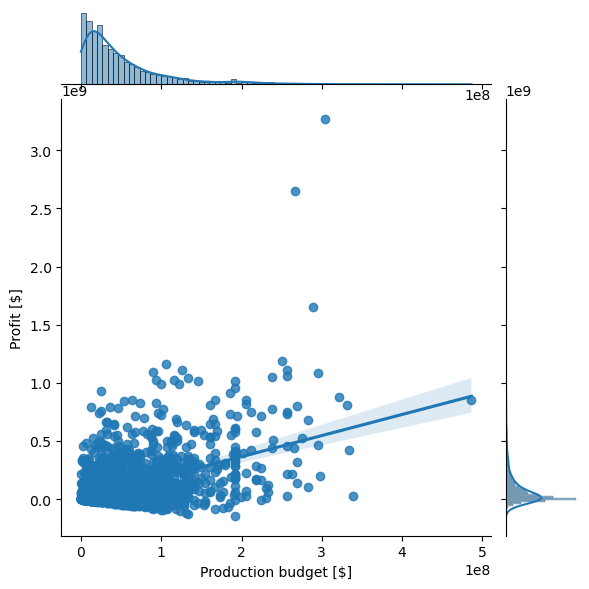

In [ ]:
h = sns.jointplot(data=df_all, x='budget_modified', y='profit_modified', kind="reg");
h.ax_joint.set_xlabel('Production budget [$]');
h.ax_joint.set_ylabel('Profit [$]');

As we can see from the plot above, the positive trend line indicates that an increase in the budget will result in an increase in profit. However, there seems to be a lot of outliers. For our datastory (Milestone 3), it would be interesting to split this into two categories, high budget movies and average movies. Additionnaly, we will want to investigate if this budget trend is different across genres.

To compare the link between all three features, we build the pairplot below:

In [ ]:
sns.pairplot(movie_feature_with_budget[['budget_modified','profit_modified','WR']]);

NameError: name 'movie_feature_with_budget' is not defined

### Top 20 most profitable movies

In [ ]:
Top20_ProfitableMovies = df_all.sort_values('profit_modified', ascending=False).head(20)

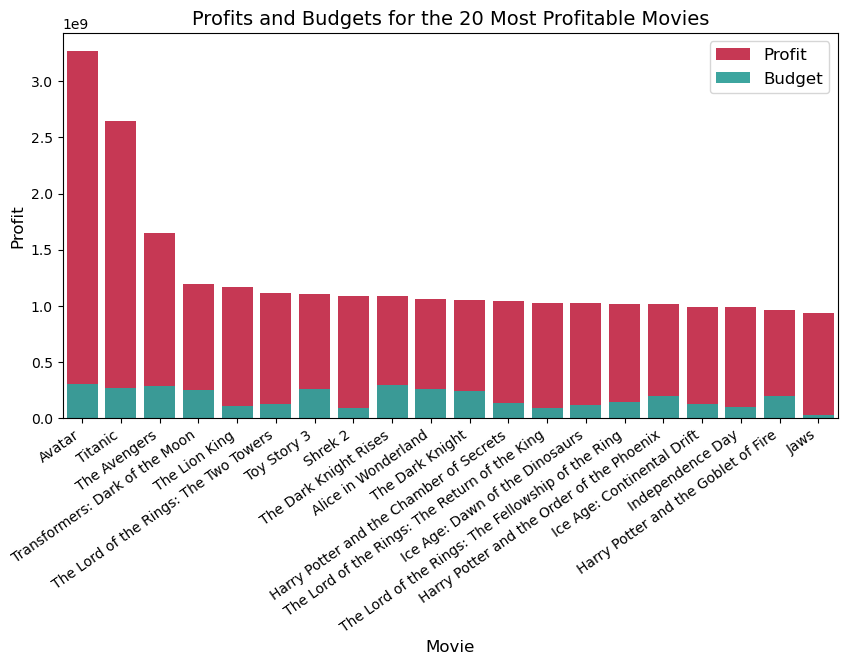

In [ ]:
plt.figure(figsize=(10,5))
sns.barplot(x=Top20_ProfitableMovies['name'],y=Top20_ProfitableMovies['profit_modified'], 
            color='crimson', alpha=0.95, label='Profit', ci=None)
sns.barplot(x=Top20_ProfitableMovies['name'],y=Top20_ProfitableMovies['budget_modified'], 
            color='lightseagreen', alpha=0.95, label='Budget', ci=None)
plt.xlabel('Movie', fontsize=12)
plt.title("Profits and Budgets for the 20 Most Profitable Movies", fontsize=14)
plt.ylabel('Profit', fontsize=12)
plt.xticks(rotation=35, horizontalalignment='right', fontsize=10)
plt.legend(fontsize=12)

## Impact of director

In [ ]:
(df_all_expanded['name'] + df_all_expanded['release_year'].astype('string')).duplicated() == False

0         True
0        False
0        False
0        False
0        False
         ...  
82603    False
82603    False
82604     True
82604    False
82604    False
Length: 916591, dtype: bool

In [ ]:
df_all_expanded.head()

,freebase_id,name,runtime,languages,countries,release_year,isAdult,directors,writers,WR,genre,release_day,release_month,profit_modified,total_gross_modified,budget_modified,pageviews
0,/m/03vyhn,Ghosts of Mars,98.0,English,United States of America,2001.0,0.0,John Carpenter,Larry Sulkis,4.900185,Thriller,24.0,8.0,NaN,1.870026e+07,NaN,16013.456439
0,/m/03vyhn,Ghosts of Mars,98.0,English,United States of America,2001.0,0.0,John Carpenter,John Carpenter,4.900185,Thriller,24.0,8.0,NaN,1.870026e+07,NaN,16013.456439
0,/m/03vyhn,Ghosts of Mars,98.0,English,United States of America,2001.0,0.0,John Carpenter,Larry Sulkis,4.900185,Science Fiction,24.0,8.0,NaN,1.870026e+07,NaN,16013.456439
0,/m/03vyhn,Ghosts of Mars,98.0,English,United States of America,2001.0,0.0,John Carpenter,John Carpenter,4.900185,Science Fiction,24.0,8.0,NaN,1.870026e+07,NaN,16013.456439
0,/m/03vyhn,Ghosts of Mars,98.0,English,United States of America,2001.0,0.0,John Carpenter,Larry Sulkis,4.900185,Horror,24.0,8.0,NaN,1.870026e+07,NaN,16013.456439


In [ ]:
print(f"Out of {df_all.shape[0]} movies in out dataset, we have the director information for {df_all_expanded[(df_all_expanded['name'] + df_all_expanded['release_year'].astype('string')).duplicated() == False]['directors'].count()} movies coming from the IMDB data set.")

Out of 82605 movies in out dataset, we have the director information for 43724 movies coming from the IMDB data set.


In [ ]:
df_director = df_all_expanded.dropna(how='all', subset=['directors']).drop_duplicates(['name', 'release_year', 'directors']) # Remove NaN directors

In [ ]:
Top20_ProfitableMovies = df_director.sort_values('profit_modified', ascending=False).head(20)

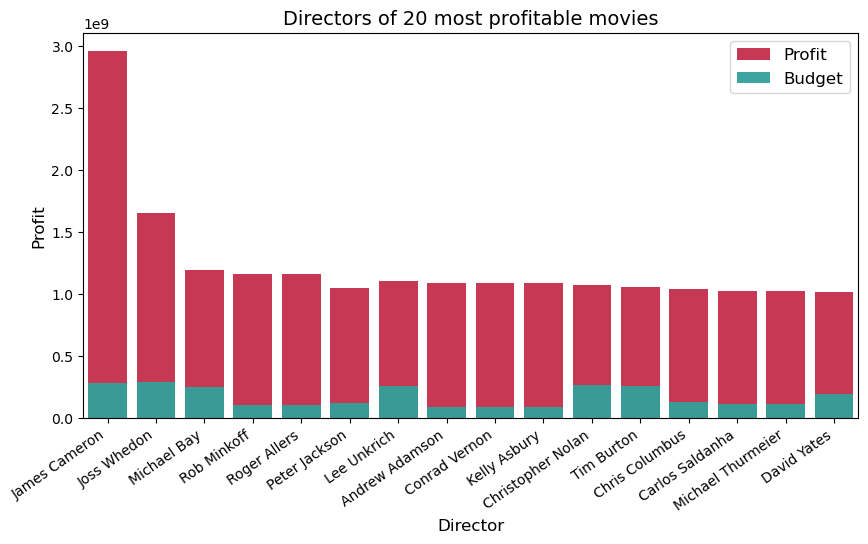

In [ ]:
plt.figure(figsize=(10,5))
sns.barplot(x=Top20_ProfitableMovies['directors'], y=Top20_ProfitableMovies['profit_modified'], 
            color='crimson', alpha=0.95, label='Profit', ci=None)
sns.barplot(x=Top20_ProfitableMovies['directors'], y=Top20_ProfitableMovies['budget_modified'], 
            color='lightseagreen', alpha=0.95, label='Budget', ci=None)
plt.xlabel('Director', fontsize=12)
plt.title("Directors of 20 most profitable movies", fontsize=14)
plt.ylabel('Profit', fontsize=12)
plt.xticks(rotation=35, horizontalalignment='right', fontsize=10)
plt.legend(fontsize=12)

In [ ]:
Top20_ProfitableMovies['directors']

23686        James Cameron
22242        James Cameron
28169          Joss Whedon
18633          Michael Bay
21419          Rob Minkoff
21419         Roger Allers
8815         Peter Jackson
69462          Lee Unkrich
59304       Andrew Adamson
59304        Conrad Vernon
59304         Kelly Asbury
54637    Christopher Nolan
9713            Tim Burton
38115    Christopher Nolan
41152       Chris Columbus
80736        Peter Jackson
38400      Carlos Saldanha
38400    Michael Thurmeier
79796        Peter Jackson
17912          David Yates
Name: directors, dtype: object

## Impact of actors

In order to assess the added value of actors to a movie's success, it is necessary to define the success of individual actors. To do this, we first create an actors dataset. We also compute in how many films in the dataset the actor appears, this value can be found in the column `num_movies`.

In [ ]:
characters
pd.merge(characters, df_all, how='left', left_on='freebase_movie_id', right_on='freebase_id')

NameError: name 'characters' is not defined

In [ ]:
actors = pd.merge(characters, df_all, how='left', left_on='freebase_movie_id', right_on='freebase_id')
actors = actors[['freebase_actor_id', 'freebase_movie_id', 'actor_name', 'actor_gender', 'actor_height_meters', 'ethnicity_label', 'major_ethnicity', 'WR']]
actors = actors.dropna(subset=['freebase_actor_id'])
#actors['mean_WR'] = actors.groupby(by=['freebase_actor_id']).mean(numeric_only=True)['WR']

actors['num_movies'] = actors.groupby(by=['freebase_actor_id'])['freebase_actor_id'].transform('size')
actors['WR_mean'] = actors[['freebase_actor_id', 'WR']].groupby(by=['freebase_actor_id']).transform('mean')
actors.drop(['freebase_movie_id'], axis=1, inplace=True)
actors.drop_duplicates(subset=['freebase_actor_id'], inplace=True)


In [ ]:
characters.groupby('actor_name').count()

In [ ]:
#Apply weighting to score
WR_actors_mean = np.mean(actors.WR_mean)
min_movies = 1

def isNan(value):
    return value!=value

def get_weigthed_WR(WR, num_movies):
    if not isNan(WR) and not isNan(num_movies):
        if num_movies > min_movies:
            return num_movies/(num_movies + min_movies) * WR + min_movies/(num_movies + min_movies) * WR_actors_mean
    return np.nan

actors['WR'] = actors.apply(lambda row: get_weigthed_WR(row['WR_mean'], row['num_movies']), axis=1)



In [ ]:
actors.head()

In [ ]:
top_20_actors = actors.dropna(subset=['WR']).sort_values(by='WR', ascending=False).iloc[0:20]

top_20_actors.head()

In [ ]:
plt.figure(figsize=(10,5));
sns.barplot(x=top_20_actors['actor_name'],y=top_20_actors['WR'], 
            color='crimson', alpha=0.95, ci=None);
plt.xlabel('Actors', fontsize=12);
plt.title("Top 20 successful actors", fontsize=14);
plt.ylabel('Success score', fontsize=12);
plt.xticks(rotation=35, horizontalalignment='right', fontsize=10);

### TO UPDATE ANYTHING BELOW

In [ ]:
print(f"Out of {df_all.shape[0]} movies in out dataset, we have the 1st actor information for {df_all['Star1'].count()} movies coming from the top 1000 IMDB data set.")

For now, we only consider the main actor of a movie but this can be extrapolated to all actors accross multiple movies for our next milestone. 

In [ ]:
df_main_actor = df_all.dropna(how='all', subset=['Star1']) # Remove NaN actors

In [ ]:
Top20_ProfitableMovies = df_main_actor.sort_values('profit_modified', ascending=False).head(20)

In [ ]:
plt.figure(figsize=(10,5))
sns.barplot(x=Top20_ProfitableMovies['Star1'],y=Top20_ProfitableMovies['profit_modified'], 
            color='crimson', alpha=0.95, label='Profit', ci=None)
sns.barplot(x=Top20_ProfitableMovies['Star1'],y=Top20_ProfitableMovies['budget_modified'], 
            color='lightseagreen', alpha=0.95, label='Budget', ci=None)
plt.xlabel('Actors', fontsize=12)
plt.title("Actors of 20 most profitable movies", fontsize=14)
plt.ylabel('Profit', fontsize=12)
plt.xticks(rotation=35, horizontalalignment='right', fontsize=10)
plt.legend(fontsize=12)

For our datastory, the goal would be to cluster actors accross genres. That way, we can forecast which actor would be best to select for a particular genre to boost success.

## Popular features in characters

The characters table is splitted between actors and actresses to study each gender as a whole different group.

In [ ]:
characters_male = characters[characters['actor_gender'] == 'M']
characters_female = characters[characters['actor_gender'] == 'F']

The following plot presents the height distribution for the actors and actresses. We can see that men tend to be taller than women actors. Also, it can be seen that in the dataset there are way more men than women

In [ ]:
def filter_children(characters):
    LIMIT_CHILDREN_AGE = 14
    return characters[(characters['actor_age_at_movie_release'] > LIMIT_CHILDREN_AGE)]

def characters_height_histogram(characters, bins):
    characters_height = characters.dropna(subset=['actor_height_meters'])
    plt.hist(characters_height['actor_height_meters'],bins=bins, alpha=0.5)
    plt.legend(['Males', 'Females'])
    plt.xlabel('Adult actor height (m)')
    plt.title('Height distribution of adult actors')

characters_height_histogram(filter_children(characters_male), bins=40)
characters_height_histogram(filter_children(characters_female), bins=25)


Another important characteristic we can study is the age on movie release. Again, there is a huge difference between women and men. Women play roles when they are younger, while men seem to have longer careers.

In [ ]:
def characters_age_histogram(characters):
    characters_age = characters.dropna(subset=['actor_age_at_movie_release']).sort_values(by=['actor_age_at_movie_release'])
    characters_age = characters_age[characters_age['actor_age_at_movie_release'] > 0]
    plt.hist(characters_age['actor_age_at_movie_release'], bins=45, alpha=0.5)
    plt.legend(['Males', 'Females'])
    plt.xlabel('Actor age at movie release')
    plt.title('Age at movie release distribution of actors')

characters_age_histogram(characters_male)
characters_age_histogram(characters_female)

The following plot shows the ethnicity distribution for actors and actresses of the dataset. It can be seen how white people clearly dominate the characters dataset by more than a half of it. Indians are also a big group representing 1/4 of the ethnicities. In this case, the difference between genders is not that big.

In [ ]:
def pie_chart_actor_ethnicities(actors, title, ax):
    actors_ethnicity = actors.dropna(subset=['major_ethnicity'])
    actors_ethnicity = actors_ethnicity[actors_ethnicity['major_ethnicity'] != 'unknown']
    ethnicities, counts = np.unique(actors_ethnicity['major_ethnicity'], return_counts=True)
    #print(np.sort(counts))
    others_count = 0
    plot_ethnicities = []
    plot_counts = []
    ETHNICITY_THRESHOLD = 1
    for ethnicity, count in zip(ethnicities, counts):
        if count > ETHNICITY_THRESHOLD:
            plot_ethnicities.append(ethnicity)
            plot_counts.append(count)
        else:
            others_count += count

    colors = ['#e8bd9b','#402b28','#996044','#dba577','#f0dfd7']

    ax.pie(plot_counts, labels=plot_ethnicities, startangle=90,autopct='%1.1f%%',colors=colors, radius=1)
    ax.set_title(title)

def two_pie_charts_actor_ethnicities(actors1, actors2, title, title1, title2):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_facecolor('white')
    fig.set_size_inches(11, 5)
    fig.suptitle(title)

    pie_chart_actor_ethnicities(actors1, title1, ax1)
    pie_chart_actor_ethnicities(actors2, title2, ax2)
    plt.show()


two_pie_charts_actor_ethnicities(characters_male, 
                                 characters_female, 
                                 title='Ethnicity distribution', 
                                 title1='Actors', 
                                 title2='Actresses')

The next plot shows the number of different ethnicities per movie. For instance, a movie that includes at least one Indian and one Black actress has 2 different ethnicities. As we can see, the vast majority of the films only have one ethnicity on it.

In [ ]:
def plot_different_ethnicities_per_movie(characters):
    ethnicity_characters = characters.dropna(subset=['major_ethnicity'])
    num_different_ethnicities = ethnicity_characters.groupby(by=['freebase_movie_id'])['major_ethnicity'].nunique()
    num_ethnicies, count = np.unique(num_different_ethnicities, return_counts=True)
    plt.bar(num_ethnicies, count)
    plt.xlabel('Number of different major ethnicities')
    plt.ylabel('Number of movies')
    plt.title('Distribution of different ethnicities per movie')
plot_different_ethnicities_per_movie(characters)

Again, let's split actors in genders

In [ ]:
actors_male = actors[actors['actor_gender'] == 'M']
actors_female = actors[actors['actor_gender'] == 'F']

And now we can focus on the actors that have appeared in a greater number of movies. We fix this threshold at 15 movies.

In [ ]:
def get_most_demanded_actors(actors, min_num_movies):
    return actors[actors['num_movies'] >= min_num_movies]

MIN_NUM_MOVIES_DEMANDED_ACTOR = 5
demanded_actors_male = get_most_demanded_actors(actors_male, MIN_NUM_MOVIES_DEMANDED_ACTOR)
demanded_actors_female = get_most_demanded_actors(actors_female, MIN_NUM_MOVIES_DEMANDED_ACTOR)


This way, we can compare if the most characteristic features of each actor are the same for the whole dataset of characters. We are plotting again the height distribution both for males and females.

In [ ]:
characters_height_histogram(demanded_actors_male, 40)
characters_height_histogram(demanded_actors_female, 15)

Also, the ethnicities are plotted again. We can observe that discriminations are even bigger.

In [ ]:
two_pie_charts_actor_ethnicities(demanded_actors_male, 
                                demanded_actors_female, 
                                 title='Top actors ethnicity distribution', 
                                 title1='Actors', 
                                 title2='Actresses')

All these data about characters is going to be merged and analysed for the last milestone. By now, we have demonstrated that we have data enough to work and answer the proper questions

Get score for actors and actresses

In [ ]:
df_test = df_all.dropna(subset=['WR'])
df_test.sort_values(by='WR', ascending=False)

# def isNaN(string):
#     return string!=string

# def get_movie_feature_by_id(freebase_movie_id, feature):
#     if not isNaN(freebase_movie_id):
#         #print(freebase_movie_id)
#         a = df_test.loc[df_all['freebase_id'] == freebase_movie_id]
#         if (len(a) > 0):
#             print(a[feature])
#             return a[feature][0].item()
#     return np.nan


# # characters['movie_score'] = characters.apply(lambda row : get_movie_feature_by_id(row['freebase_movie_id'], 'WR'), axis=1)

# # characters.dropna(subset='movie_score')

# # characters.iloc[0]['freebase_movie_id']

# characters.apply(lambda row : get_movie_feature_by_id(row['freebase_movie_id'], 'WR'), axis=1)


## What genres are the most profitable?

In [ ]:
df_all['profit_modified'].plot(kind='hist', logy=True, histtype='step', title='Movie profit distribution');

In [ ]:
df_genre = df_all_expanded.dropna(how='all', subset=['genre']).drop_duplicates(['name', 'release_year', 'genre'])

In [ ]:
genres = df_genre['genre'].value_counts()

In [ ]:
genres[genres > 1000].plot(kind='bar', title='Movie genres distribution');

In [ ]:
plt.figure(figsize=(15,5));
ax = sns.barplot(
    x="genre",
    y="profit_modified",
    data=df_genre[df_genre['profit_modified'].notna() & df_genre['genre'].isin(genres[genres > 1000].index.to_list())],
    palette='crest'
)
plt.xlabel('Genre', fontsize=12)
plt.ylabel('Profit', fontsize=12)
plt.title('Success of Movie based on genre in terms of the profit', fontsize=14)
_ = plt.xticks(rotation=90)

## Correlation between the choice of topics and movie profitability can be investigated

In [ ]:
df_genre['genre_category'] = df_genre['genre'].astype('category').cat.codes

In [ ]:
fig, ax = plt.subplots(figsize=(15,7))
sns.heatmap(df_genre.corr(), annot=True, ax=ax).set(title='Heat map of correlations between different movie features');

## Clustering between movies: Classics VS forgettable : check with wikipedia ID how much it is visited : time series of access 

In [ ]:
wikipedia_pageviews.sample(5)

In [ ]:
df_all_ohe.sample(5)

In [ ]:
df_all_ohe_cleaned_columns = df_all_ohe.rename({c: c.replace('/', '').replace('.', '').replace(' ', '').replace('\'', '').replace('-', '') for c in df_all_ohe.columns}, axis=1)

In [ ]:
mod = smf.ols(formula=
    'pageviews ~ runtime + release_year + WR + release_month + profit_modified + genre_Action + ' +
    'genre_ActionAdventure + genre_Adventure + genre_Animation + genre_Blackandwhite + genre_Comedy + ' +
    'genre_Comedyfilm + genre_CrimeFiction + genre_Documentary + genre_Drama + genre_FamilyFilm + ' + 
    'genre_Fantasy + genre_Horror + genre_Indie + genre_Musical + genre_Mystery + genre_Other + ' + 
    'genre_RomanceFilm + genre_Romanticcomedy + genre_Romanticdrama + genre_ScienceFiction + genre_ShortFilm + ' + 
    'genre_Silentfilm + genre_Thriller + genre_Warfilm + genre_Worldcinema + languages_Cantonese + ' + 
    'languages_English + languages_French + languages_German + languages_Hindi + languages_Italian + ' + 
    'languages_Japanese + languages_Korean + languages_Malayalam + languages_Other + languages_Russian + ' + 
    'languages_Silentfilm + languages_Spanish + languages_StandardMandarin + languages_Tamil + languages_Telugu + ' + 
    'countries_Argentina + countries_Australia + countries_Canada + countries_France + countries_Germany + ' + 
    'countries_HongKong + countries_India + countries_Italy + countries_Japan + countries_Mexico + ' + 
    'countries_Netherlands + countries_Other + countries_SouthKorea + countries_Spain + countries_UnitedKingdom + ' + 
    'countries_UnitedStatesofAmerica + directors_AlfredHitchcock + directors_CecilBDeMille + ' + 
    'directors_CharlesChaplin + directors_CharlesLamont + directors_ChuckJones + directors_DWGriffith + ' + 
    'directors_DaveFleischer + directors_FrizFreleng + directors_GeorgeCukor + directors_GeorgeMarshall + ' + 
    'directors_GordonDouglas + directors_HenryHathaway + directors_JohnFord + directors_JosephBarbera + ' + 
    'directors_JosephKane + directors_JulesWhite + directors_MichaelCurtiz + directors_NormanTaurog + ' + 
    'directors_Other + directors_RaoulWalsh + directors_RayTaylor + directors_RichardThorpe + directors_RobertFMcGowan + ' + 
    'directors_RobertFlorey + directors_RobertMcKimson + directors_RoscoeFattyArbuckle + directors_SamNewfield + ' + 
    'directors_WilliamAWellman + directors_WilliamBeaudine + directors_WilliamHanna + directors_WilliamWitney + ' + 
    'writers_ArthurConanDoyle + writers_BasilDickey + writers_BenHecht + writers_CareyWilson + writers_CharlesChaplin + ' + 
    'writers_CharlesDickens + writers_DWGriffith + writers_DudleyNichols + writers_EdgarRiceBurroughs + writers_ElwoodUllman + ' + 
    'writers_FelixAdler + writers_FrancesMarion + writers_GeorgeHPlympton + writers_GopalakrishnaParuchuri + writers_HMWalker + ' + 
    'writers_HalRoach + writers_JohnWDunn + writers_KaderKhan + writers_MichaelMaltese + writers_NunnallyJohnson + writers_Other + ' + 
    'writers_ParuchuriVenkateswaraRao + writers_RahiMasoomReza + writers_RobertAMcGowan + writers_SachinBhowmick + writers_Satyanand + ' + 
    'writers_StephenKing + writers_TeddPierce + writers_ValGuest + writers_WarrenFoster + writers_WilliamShakespeare',
  data=df_all_ohe_cleaned_columns)
np.random.seed(2)
res = mod.fit()
res.summary()

## Countries

In [ ]:
# sort by country
import json
movies_header = ['wikipedia_id', 'freebase_id', 'name', 'release_date', 'box_office_revenue', 'runtime', 'languages', 'countries', 'genres']
movies = pd.read_csv('data/movie.metadata.tsv', sep='\t', header=None, names=movies_header)
data = pd.read_csv('data/movie.metadata.tsv', sep='\t', header=None, names=movies_header)
movies.head(5)
print(movies.shape)
# movies=movies['countries'].apply(lambda row: len((eval(row).values())))
movies=movies['countries'].apply(lambda row: (eval(row).values()))
movies= pd.DataFrame(movies,columns=['countries'])
# movies['countries'].apply(len)
# movies.describe()
movies.head()


In [ ]:


# movies=movies['countries'].apply(lambda row: (eval(row).values()))
# movies= pd.DataFrame(movies,columns=['countries'])
exploded=pd.DataFrame([[c] for C in movies['countries'] for c in C],columns=['countries'])
len(exploded['countries'].unique())
count=exploded['countries'].value_counts()
count.to_csv('test.csv')
# US=movies['countries'].apply(lambda lis : "United States of America" in lis and len(lis)==1)
US=movies['countries'].apply(lambda lis : "United States of America" in lis)
US_movies=data.loc[US]
print('number of movies made in the US: ',US.sum())
IN=movies['countries'].apply(lambda lis : "India" in lis)
IN_movies=movies[IN]
print('number of movies made in india: ',IN.sum())

mult=movies['countries'].apply(lambda lis : len(lis)>1)
print('number of movies made in more than one country: ',sum(mult))


In [ ]:

# one list with all the countries of all the movies
exploded=pd.DataFrame([[c] for C in movies['countries'] for c in C],columns=['countries'])
len(exploded['countries'].unique())
count=exploded['countries'].value_counts()
count.to_csv('handled_data/test.csv')


In [ ]:



from matplotlib import pyplot as plt
fig, ax = plt.subplots(figsize=(15,7))
plt.bar(count.head(20).index.to_series(),count.head(20))
plt.xticks(rotation=60, horizontalalignment='right', fontsize=12);
from matplotlib import pyplot as plt
fig, ax = plt.subplots(figsize=(15,7))
plt.bar(count[1:51].index.to_series(),count[1:51])
plt.xticks(rotation=60, horizontalalignment='right', fontsize=12);


In [ ]:


# sort movies by date 
data[(data['release_date']<'2000') & (data['release_date']>='1995')]
set1=data[data['release_date']<'1985']
set2=data[data['release_date']>'1985']
set1=set1['countries']
set2=set2['countries']
def analysis(set) :
    set=set.apply(lambda row: (eval(row).values()))
    set= pd.DataFrame(set,columns=['countries'])
    exploded=pd.DataFrame([[c] for C in set['countries'] for c in C],columns=['countries'])
    # len(exploded['countries'].unique())
    count=exploded['countries'].value_counts()
    count.to_csv('test.csv')
    return count

c1=analysis(set1)
c2=analysis(set2)


In [ ]:
fig, ax = plt.subplots(figsize=(11,5))
# fig.set_facecolor('white')
# fig.set_size_inches(11, 5)
# fig.suptitle('title')
plot_counts=c1.head(5)
plot_countries=plot_counts.index.to_series()
ax.pie(plot_counts, labels=plot_countries, startangle=90,autopct='%1.1f%%', radius=1)
ax.set_title('top 5 countries by number of movies before 1985')
plt.show()
# plot_countries


In [ ]:

fig, ax = plt.subplots(figsize=(11,5))
# fig.set_facecolor('white')
# fig.set_size_inches(11, 5)
# fig.suptitle('title')
plot_counts=c2.head(5)
plot_countries=plot_counts.index.to_series()
ax.pie(plot_counts, labels=plot_countries, startangle=90,autopct='%1.1f%%', radius=1)
ax.set_title('top 5 countries by number of movies after 1985')
plt.show()

# Train NN for predicting revenue

In [ ]:
df_all_ohe.columns

In [ ]:
movies

In [ ]:
df_all.describe()

In [ ]:
df_all_ohe.describe()

In [ ]:
movies_with_gross = df_all_ohe[df_all_ohe['pageviews'].notna()]

In [ ]:
movies_with_gross.drop(['freebase_id', 'name', 'release_day', 'profit_modified'], axis=1, inplace=True)

In [ ]:
movies_with_gross.head()

In [ ]:
movies_with_gross.describe()

In [ ]:
movies_with_gross.shape

In [ ]:
list(movies_with_gross.columns)

In [ ]:
movies_with_gross = movies_with_gross.astype('float32')

In [ ]:
dataset = movies_with_gross.copy()

In [ ]:
train_dataset = dataset.sample(frac=0.8, random_state=0)
test_dataset = dataset.drop(train_dataset.index)

In [ ]:
train_dataset.describe().transpose()

In [ ]:
train_features = train_dataset.copy()
test_features = test_dataset.copy()

train_labels = train_features.pop('pageviews')
test_labels = test_features.pop('pageviews')

In [ ]:
train_features.shape

In [ ]:
from tensorflow.python.keras.layers import Dense
from tensorflow.keras.layers import Normalization
from tensorflow.python.keras.models import Sequential

# from tensorflow.keras.metrics import Recall, Precision
# from tensorflow_addons.metrics import F1Score

total_gross_modified ~ runtime + release_year + isAdult + WR + release_month + budget_modified + pageviews + genre + languages + countries + directors + writers

In [ ]:
model = Sequential()
model.add(Normalization(axis=-1))
model.add(Dense(50, activation="relu"))
model.add(Dense(25, activation="relu"))
model.add(Dense(1))

In [ ]:
model.compile(optimizer='adam', loss='mean_absolute_error', metrics=['accuracy'])

In [ ]:
model.build((0, 127))
model.summary()

In [ ]:
history = model.fit(train_features, train_labels, batch_size=32, epochs=10, validation_split=0.2)

# Project Milestone 3: data story

## Study data for separate genre

In [ ]:
# Create list of top 15 genre: 
print(genres[genres>1000][0:15])
top_genre = genres[genres>1000][0:15].index.tolist()

## Top movies for three success features

We sort df_all by most successful movies according to our three success features. Note that we keep here duplicates for future use.

In [ ]:
# Success in terms of profit: 
df_all_top_profit = df_all_expanded.sort_values('profit_modified', ascending=False)
df_all_top_profit.head(3)

In [ ]:
# Success in terms of wikipedia pageviews: 
df_all_top_pageviews = df_all_expanded.sort_values('pageviews', ascending=False)
df_all_top_pageviews.head(3)

In [ ]:
# Success in terms of weighted IMDB rating: 
df_all_top_WR = df_all_expanded.sort_values('WR', ascending=False)
df_all_top_WR.head(3)

## Impact of director

In [ ]:
# Most succesful directors in terms of profit
top_20_directors = df_all_top_profit[df_all_top_profit['genre']=='Drama'].dropna(how='all', subset=['directors']).drop_duplicates(['name', 'release_year', 'directors'])[0:20] # Remove NaN directors

In [ ]:
plt.figure(figsize=(10,5))
sns.barplot(x=top_20_directors['directors'],y=top_20_directors['profit_modified'], 
            color='crimson', alpha=0.95, label='Profit', ci=None)
sns.barplot(x=top_20_directors['directors'],y=top_20_directors['budget_modified'], 
            color='lightseagreen', alpha=0.95, label='Budget', ci=None)
plt.xlabel('Director', fontsize=12)
plt.title("Directors of 20 most profitable movies for drama genre", fontsize=14)
plt.ylabel('Profit', fontsize=12)
plt.xticks(rotation=35, horizontalalignment='right', fontsize=10)
plt.legend(fontsize=12)

In [ ]:
import networkx as nx
import pyvis
from pyvis.network import Network

# Load pandas as networks graph
G = nx.from_pandas_edgelist(top_20_directors, source='directors',target='name',edge_attr='directors')

# Create vis network
net = Network(notebook=True)
# Load the networkx graph
net.from_nx(G)
# Show
net.show("example.html")





In [ ]:
top_20_directors.head()

In [ ]:

#graph esthetic parameters
max_node_size = 20000
max_edge_width = 100

#extract edges weigths, normalize them and define their width in the graph
#weights = np.array([G[u][v]['weight'] for u,v in G.edges()])
#weights = (weights - np.min(weights)) / (np.max(weights)-np.min(weights))
#weights *= max_edge_width

#extract lexical fields total scores over the whole corpus, normalize them and define their width in the graph
nodes_scores = top_20_directors['WR']
nodes_size = np.array(nodes_scores)
nodes_size = (nodes_size - np.min(nodes_size)) / (np.max(nodes_size) - np.min(nodes_size))
nodes_size *= max_node_size
                        
# Generate layout for visualization
pos = nx.circular_layout(G)

fig, ax = plt.subplots(figsize=(20, 20))

# Visualize graph components
nx.draw_networkx_edges(G, pos, alpha=0.5, edge_color="m") # width = weights
nx.draw_networkx_nodes(G, pos, node_size=nodes_size, node_color="#210070", alpha=0.9)
label_options = {"ec": "k", "fc": "white", "alpha": 0.7}
nx.draw_networkx_labels(G, pos, font_size=18, bbox=label_options)

# Resize figure for label readibility
ax.margins(0.1, 0.05)
fig.tight_layout()
plt.axis("off")

#plt.savefig('../output/network_sparse.png', dpi = 500)
plt.show()